In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

I can first start with Brownian Motion. Brownian Motion and Wiener Processes are the same thing and will be used interchangeably. I will use $B_t$ to represent the brownian motion at a specific time $t$. Brownian motion is not only continuous over time, but displays a fractal behaviour when zoomed into a specific part. Therefore I will simply take the exact value of the Brownian Motion at a discrete set of time points and use this to be a discretized model of the Brownian Model path. This makes implementation of Brownian Motion much easier to compute. This is due to the increments being gaussian, and such I can simply just simulate $N$ gaussian realisations fitting:
$$
B_{t_{n}} - B_{t_{n-1}} = \epsilon_n \sim \mathcal{N}(0, dt)
$$
Then I can simply set a $B_{t_{0}} = 0$ to start the Brownian Motion at $0$ and then I can get:
$$
B_{t_{n}} = B_{t_{0}} + \sum_{i=1}^{n} \epsilon_i
$$
I have implemented this below and displayed what the Brownian Motion realisation looks like in a plot.

In [2]:
dt = 0.01
N = 10000
D = 1.0
np.random.seed(2985)
sigma = np.sqrt(2*D*dt)

e = np.random.normal(0, sigma, N-1)
B = np.zeros(N)
B[1:] = np.cumsum(e)

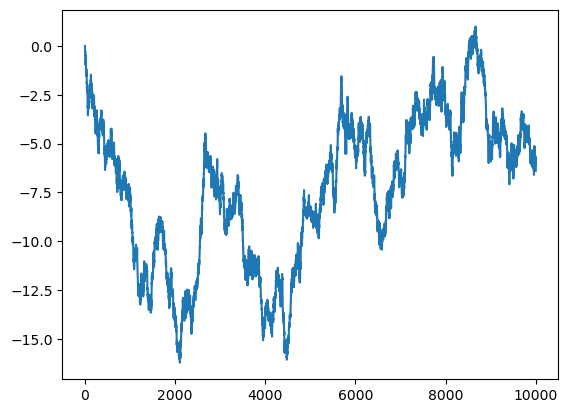

In [3]:
plt.plot(B)
plt.show()

Using this discrete Brownian Motion realisation we can then progress onto Stochastic Differential Equations. I will look at Ornstein-Uhlenbeck processes.

$e$ is our white Gaussian noise with drift value $D$. 
$W$ is our discrete Wiener process. 
$e$ can be thought of as $\Delta W$ for each time step of the Wiener process.

We can then create an Ornstein-Uhlenbeck process through the SDE:
$$
\frac{dx}{dt} = -kx + e
$$
where $k$ can be thought of as the spring constant (drag coefficient), and $e$ is the white Gaussian noise. 

We can then implement a numerical solution of this using the Euler-Maruyama method. This is done by converting the current form of our SDE back into 
$$
dx = -kxdt + dW
$$
From here we can then use the Euler-Maruyama method of:
$$
dx_t = a(x_t, t)dt + b(x_t, t)dW_t
$$
Can be approximated numerically by the following recursion:
$$
x_{n+1} = x_n + a(x_n, t_n)\Delta t + b(x_n, t_n) \Delta W_n
$$
where $\Delta t = T/N$, where $T$ is the time interval, $N$ is the total number of time steps, $\Delta W_n = e_n$, where $e_n$ is the white Gaussian noise at time step $n$. 

To apply this to our Ornstein-Uhlenbeck process we get:
$$
x_{n+1} = x_n - kx_n\Delta t + \Delta W_n
$$

I will now implement the Euler-Maruyama method that can be applied to a given Ornstein-Uhlenbeck process.

In [2]:
def EulerMaruyamaRecursion(x_n, k, dt, e_n):
    '''
    Return the x_{n+1} value using the Euler-Maruyama method recursion.
    '''
    return x_n - k*x_n*dt + e_n

def EulerMaruyamaMethod(x_0, k, T_lim, N, D):
    '''
    Complete the Euler-Maruyama method and return the approximated x values at each time value.
    '''
    dt = (T_lim[1] - T_lim[0])/N

    t = np.arange(T_lim[0], T_lim[1]+dt, dt)

    x = np.zeros(N+1)
    x[0] = x_0

    sigma = np.sqrt(2*D*dt)
    e = np.random.normal(0, sigma, N)

    for n in range(N):
        x[n+1] = EulerMaruyamaRecursion(x[n], k, dt, e[n])

    return t, x


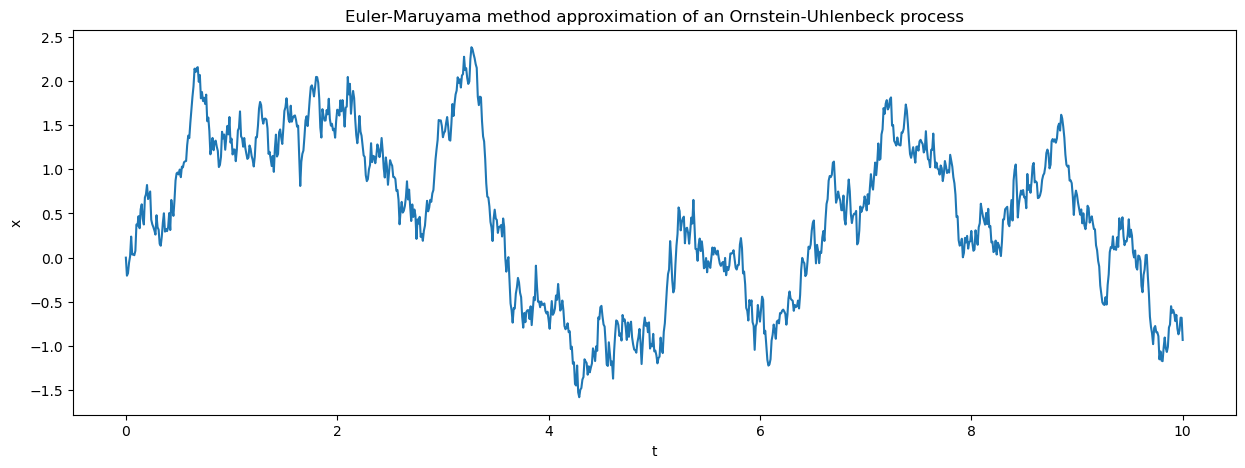

In [5]:
x_0 = 0.0
k = 1.0
T_lim = np.array([0, 10])
N = 1000
D = 1.0
t, x = EulerMaruyamaMethod(x_0, k, T_lim, N, D)
plt.figure(figsize=(15, 5))
plt.title('Euler-Maruyama method approximation of an Ornstein-Uhlenbeck process')
plt.plot(t, x)
plt.xlabel('t')
plt.ylabel('x')
plt.show()

Realisation of a simple Ornstein-Uhlenbeck process.

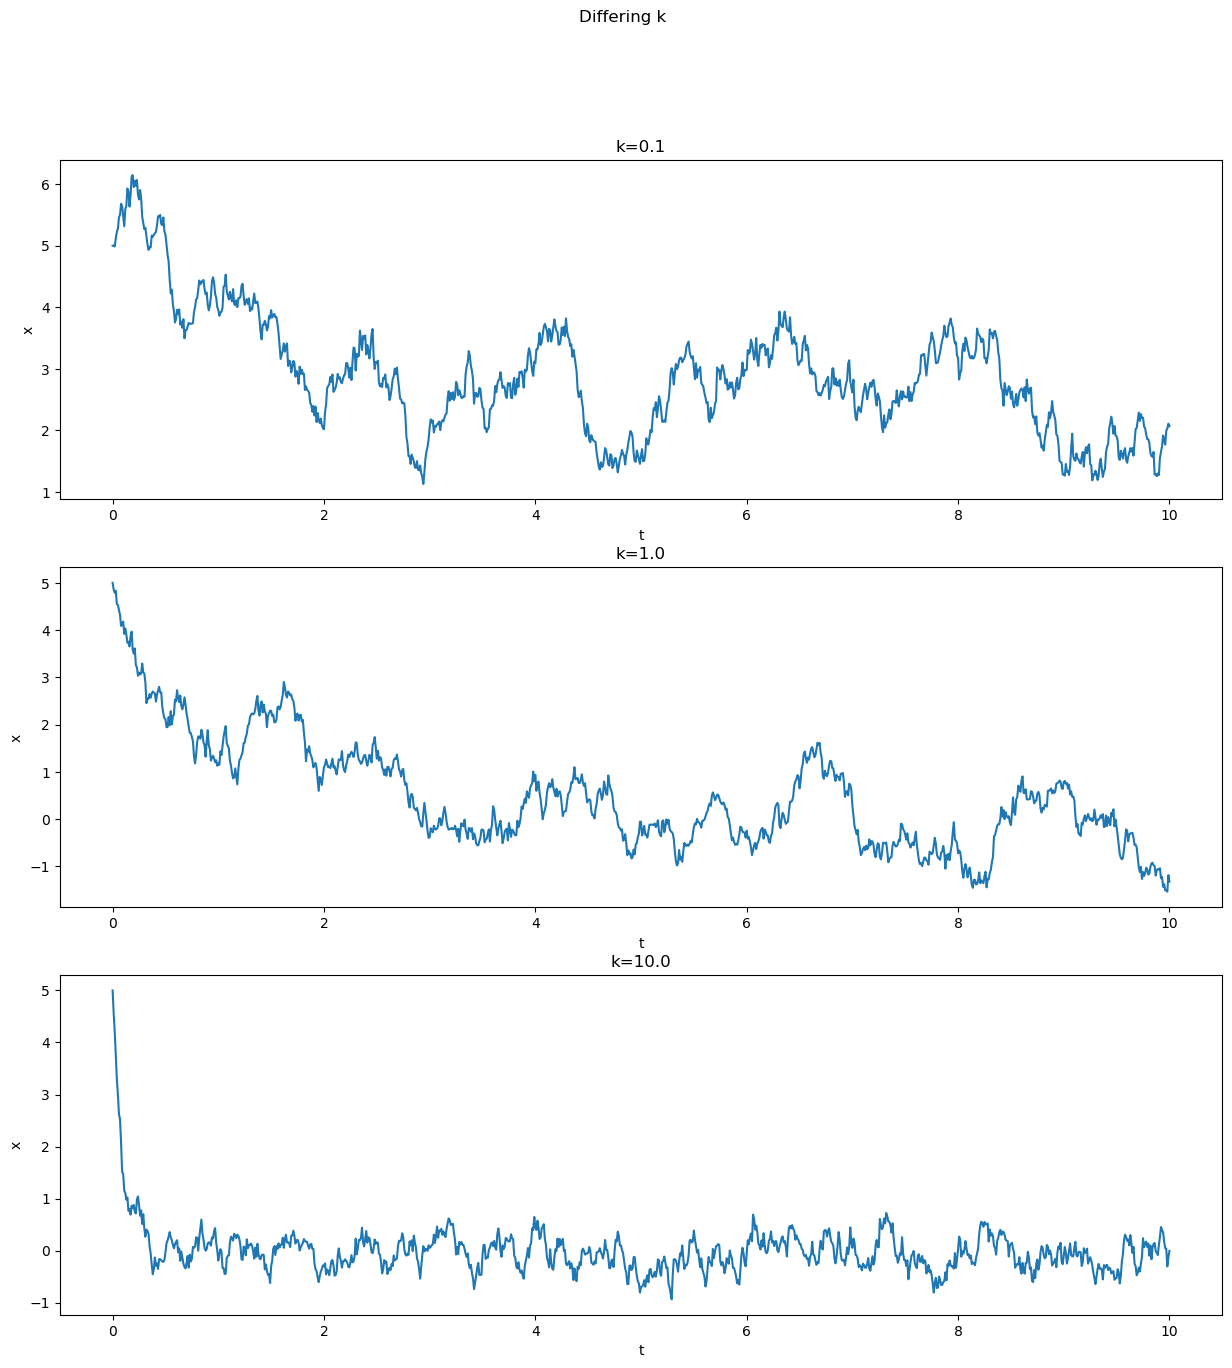

In [6]:
x_0 = 5.0
k_vals = np.array([0.1, 1.0, 10.0])
T_lim = np.array([0, 10])
N = 1000
D = 1.0
fig, axi = plt.subplots(np.size(k_vals, 0), figsize=(15, 15))
fig.suptitle('Differing k')

for i, k in enumerate(k_vals):
    t, x = EulerMaruyamaMethod(x_0, k, T_lim, N, D)
    axi[i].plot(t, x)
    axi[i].set_title(f'k={k}')
    axi[i].set_xlabel('t')
    axi[i].set_ylabel('x')



By differing k values, I can see that it effects how quickly it tends to 0 from starting in a displaced position. This makes sense in terms of a spring constant, as a stiffer spring, a higher k value, will result in the mass being pulled into the equilibrium faster and then in the future will deviate from the equilibrium less. And the opposite is true for a less stiff spring, lower k value, where it still tends towards the equilibrium but not as fast.

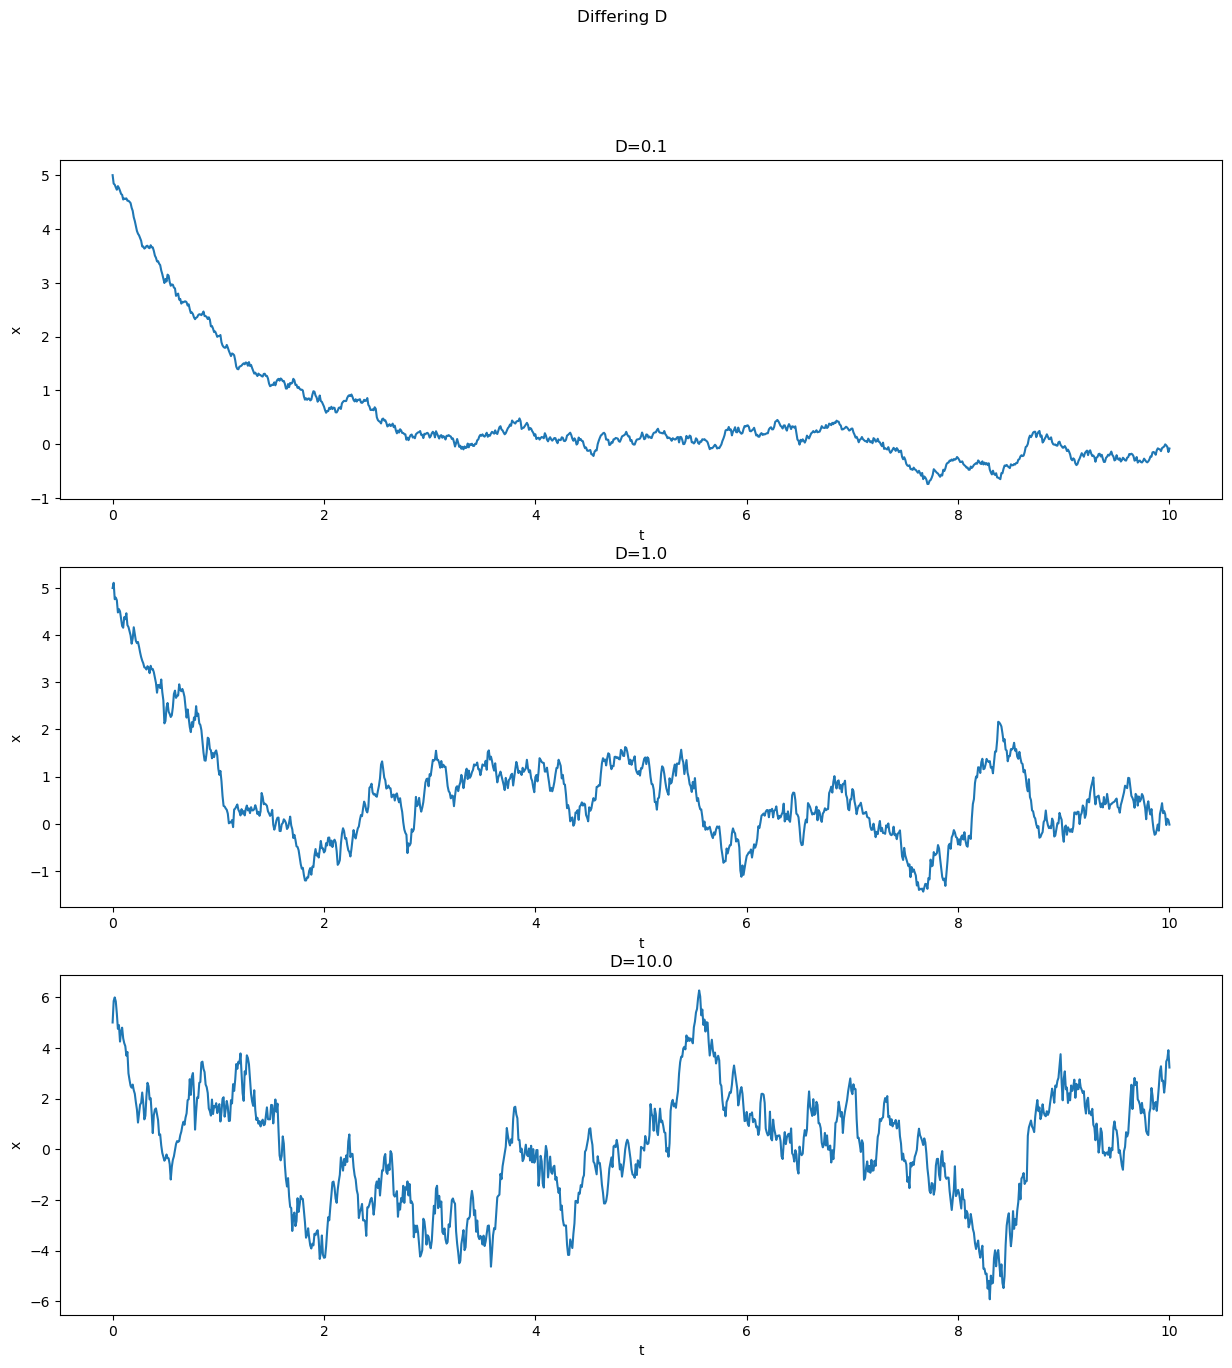

In [7]:
x_0 = 5.0
k = 1.0
T_lim = np.array([0, 10])
N = 1000
D_vals = np.array([0.1, 1.0, 10.0])
fig, axi = plt.subplots(np.size(D_vals, 0), figsize=(15, 15))
fig.suptitle('Differing D')

for i, D in enumerate(D_vals):
    t, x = EulerMaruyamaMethod(x_0, k, T_lim, N, D)
    axi[i].plot(t, x)
    axi[i].set_title(f'D={D}')
    axi[i].set_xlabel('t')
    axi[i].set_ylabel('x')

By differing D values, I can see that it effects how smooth the process is. This makes sense as the drift value D is directly proportional to the variance of the white Gaussian noise in the model. I can see that the higher drift value D, the more it deviates from a smooth curve back to the equilibrium, creating larger peaks and troughs about the equilibrium. The opposite is true for a smaller drift value D, with it being a much smoother process, not deviating too far from a smooth exponential curve back to the equilibrium. 

Next we can have a look at some approaches to finding estimates of the two parameters $k$ and $D$. 

We can start by setting $k=0$. This means that we are dealing with Brownian Motion. Now we can see the problem as just:
$$
\frac{dx}{dt} = e
$$
which is simply just the Wiener process we have seen before. From this we can then make estimates of what $D$ will be from the values of $e$ as they will follow a Gaussian distribution of mean $0$ and variance $2Ddt$. So we can work out the estimate of the variance and then using values known for $dt$ we can work out $D$. As the mean is known $\mu = 0$, we can use the maximum likelihood estimator for the variance $\sigma^2$:
$$
\hat\sigma^2 = \frac{1}{N} \sum_{i=1}^{N} (e_i)^2
$$
So then we can get an estimate of $D$ to be:
$$
D = \frac{\hat\sigma^2}{2dt}
$$

In [3]:
def EstimateVariance(x, T_lim, N):
    '''
    Return the maximum likelihood estimator of the variance when k=0 and steps follow a Gaussian Distribution
    '''
    dt = (T_lim[1]- T_lim[0])/N
    e = x[1:] - x[:-1]
    Var = np.sum(np.power(e, 2))/N
    return Var/(2*dt)

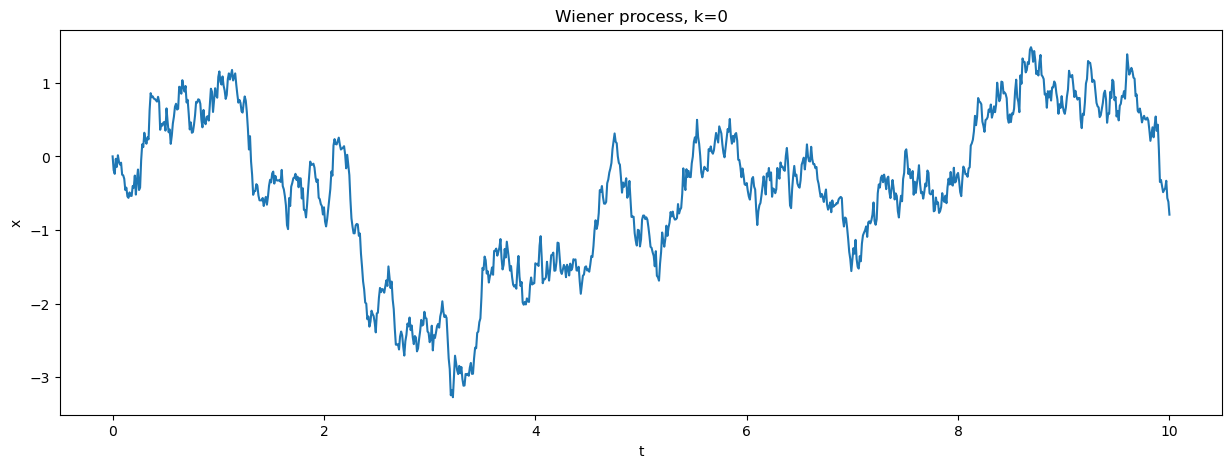

In [11]:
x_0 = 0.0
k = 0.0
T_lim = np.array([0, 10])
N = 1000
D = 1.0
t, x = EulerMaruyamaMethod(x_0, k, T_lim, N, D)
plt.figure(figsize=(15, 5))
plt.title('Wiener process, k=0')
plt.plot(t, x)
plt.xlabel('t')
plt.ylabel('x')
plt.show()

In [12]:
print(f'The actual D value is: {D}')
print(f'The estimated D value is: {EstimateVariance(x, T_lim, N)}')

The actual D value is: 1.0
The estimated D value is: 0.9914298693852569


Now I have an approximation of D for one case. I can then repeat this over and over with different values of N to find out how the approximation converges to the actual value. I am also going to plot $D-\hat D$ so that it converges to 0, and this way I can square the difference $(D-\hat D)^2$ also to see that convergence also. The reason for squaring it, is because we have a suspicion that the convence will be proportional to $\sqrt{N}$ and such by squaring the difference should get a linear convergence. 

In [54]:
x_0 = 0.0
k = 0.0
T_lim = np.array([0, 10])
N_vals = np.logspace(1, 4, 20, dtype=int)
D = 1.0
M = 10000
D_prime = np.zeros((np.size(N_vals, 0), M))

for i, N in enumerate(N_vals):
    for j in range(M):
        t, x = EulerMaruyamaMethod(x_0, k, T_lim, N, D)
        D_prime[i, j] = EstimateVariance(x, T_lim, N)


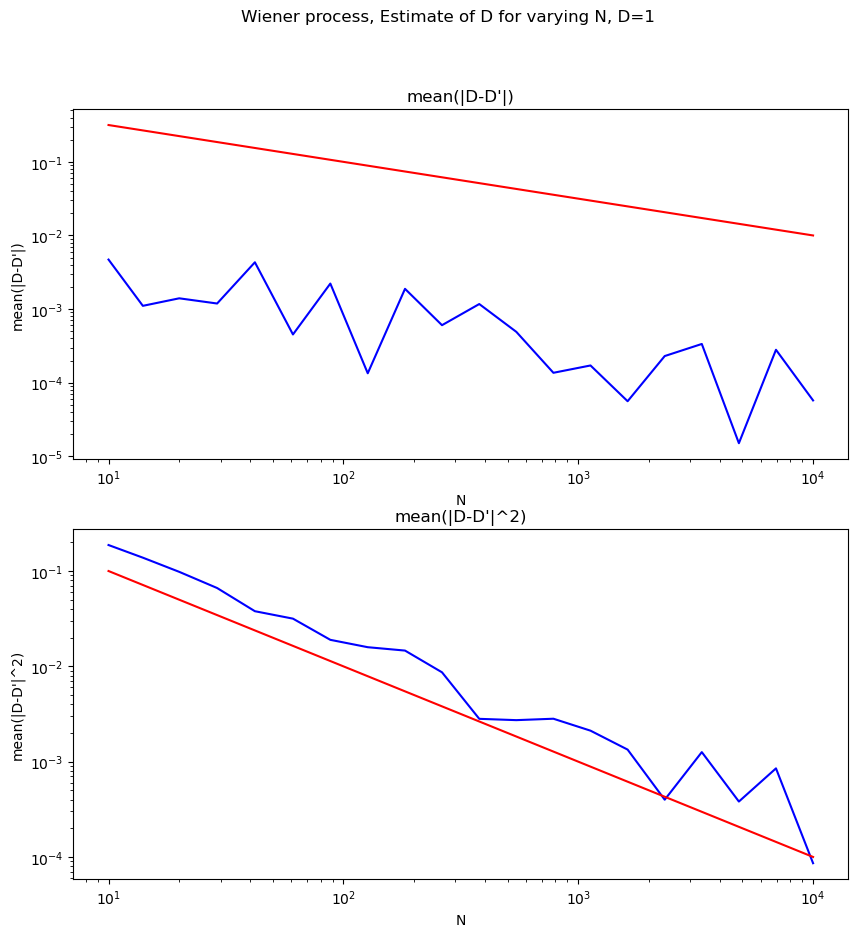

In [80]:
fig, axi = plt.subplots(2, figsize=(10, 10))
fig.suptitle('Wiener process, Estimate of D for varying N, D=1')
axi[0].set_title(f'mean(|D-D\'|)')
axi[0].set_xlabel('N')
axi[0].set_ylabel('mean(|D-D\'|)')
axi[0].set_yscale('log')
axi[0].set_xscale('log')

axi[1].set_title(f'mean(|D-D\'|^2)')
axi[1].set_xlabel('N')
axi[1].set_ylabel('mean(|D-D\'|^2)')
axi[1].set_yscale('log')
axi[1].set_xscale('log')
axi[0].plot(N_vals, np.abs(1-np.mean(D_prime, axis=1)), c='b')
axi[0].plot(N_vals, 1/np.sqrt(N_vals), c='r')
axi[1].plot(N_vals, np.abs(1-np.mean(np.power(D_prime, 2), axis=1)), c='b')
axi[1].plot(N_vals, 1/N_vals, c='r')
plt.show()

From the above plots can see that as N increaes the mean estimates of D converge. 

The first plot shows the covergence of $|D-D'|$. This shows a noisy convergence of the estimator. I was expecting a convergence of $\sqrt{N}$ which is why I have plotted a $\log$ vs $\log$ plot. This should take out the power to get a linear convergence in $\log(N)$. From this we can see a very noisy linear convergence, but the noise is very large and such makes it difficult to see a distinct pattern. I have added in a red line which shows the $\sqrt{N}$ convergence I was expecting as a reference, and when comparing the two lines I can see that they have similar gradients of convergence.

The second plot shows the convergence of $|D-D'|^2$. Given the linear convergence was expected to be $\sqrt{N}$, this should then be linear convergence in $N$. I have logged both sides so the relationship should still remain linear. From this I can see a pretty straight linear convergence. I have also plotted a red line of linear convergence as I was expecting, and when using it as a refererence it basically matches up very similar.

One thing I have noticed is that the squared plot is a much smoother convergence for the same estimate values, especially for N up to $10^3$. After this point even the squared plot starts to become noisy. Another thing is that the linear plot starts much smaller value than the squared plot and stays that way until N up to $10^3$. 

I now want to consider a fixed N, but varying the amount of times I repeat the simulation. In the previous I set this at 100, but now I am going to vary this to see how this affects the mean estimate. I am now just going to use the $|D-D'|^2$ value and plot the distribution.

In [81]:
x_0 = 0.0
k = 0.0
T_lim = np.array([0, 10])
N = 10000
D = 1.0
M_vals = np.logspace(1, 4, 20, dtype=int)
D_prime = [np.zeros(M) for M in M_vals]


for i, M in enumerate(M_vals):
    for j in range(M):
        t, x = EulerMaruyamaMethod(x_0, k, T_lim, N, D)
        D_prime[i][j] = np.abs(D-EstimateVariance(x, T_lim, N))


In [ ]:
fig, axi = plt.subplots(2, figsize=(10, 10))
fig.suptitle('Wiener process, Estimate of D for varying N, D=1')
axi[0].set_title(f'|D-D*|')
axi[0].set_xlabel('M')
axi[0].set_ylabel('|D-D*|')

axi[1].set_title(f'|D-D*|^2')
axi[1].set_xlabel('M')
axi[1].set_ylabel('|D-D*|^2')


axi[0].plot(M_vals, [np.mean(i) for i in D_prime], c='b')
axi[1].plot(M_vals, [np.mean(np.power(i, 2)) for i in D_prime], c='b')
plt.show()

The plots above show the mean estimate for a varying amount of simulations can still vary as simulations increase, but from the graph, as M is nearing 200, the estimate remains very similar and such by increasing the simulations the mean estimate converges to a value which can be taken as the actual estimate.

I can now plot the distribution of estimates like Figure 2 to see what it looks like.

In [6]:
x_0 = 0.0
k = 0.0
T_lim = np.array([0, 10])
N = 10000
D = 1.0
M = 10000
D_prime = np.zeros(M)

for i in range(M):
    t, x = EulerMaruyamaMethod(x_0, k, T_lim, N, D)
    D_prime[i] = EstimateVariance(x, T_lim, N)


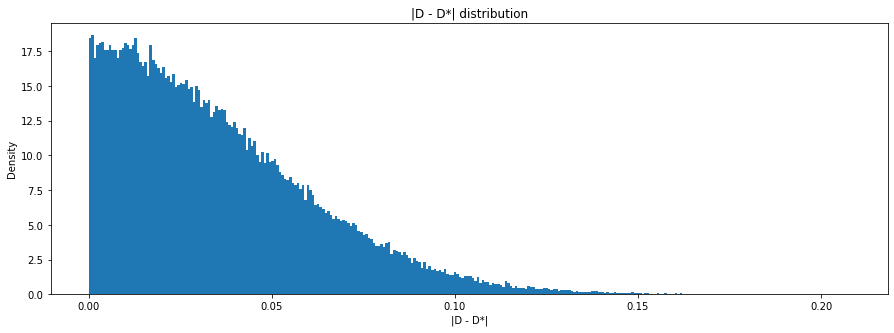

In [11]:
plt.figure(figsize=(15, 5))
plt.title('|D - D*| distribution')
plt.xlabel('|D - D*|')
plt.ylabel('Density')
plt.hist(np.abs(D-D_prime), bins=300, density=True)
plt.show()

This is a histogram representing the 

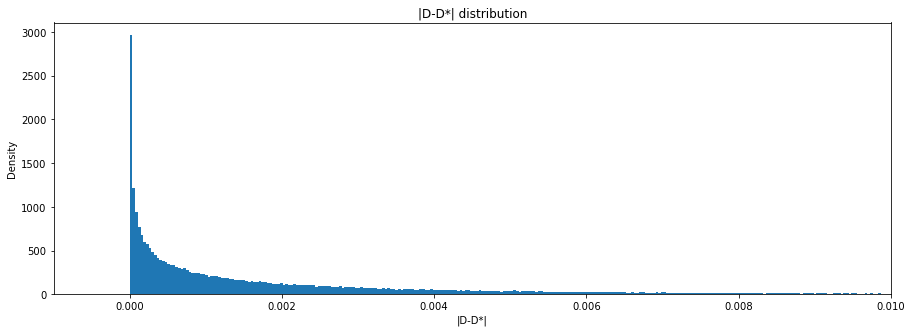

In [86]:
x_0 = 0.0
k = 0.0
T_lim = np.array([0, 10])
N = 1000
D = 1.0
M = 100000
D_prime = np.zeros(M)


plt.figure(figsize=(15, 5))
plt.title('|D-D*|^2 distribution')
plt.xlabel('|D-D*|^2')
plt.ylabel('Density')
plt.xlim([-0.001, 0.01])
for i in range(M):

    t, x = EulerMaruyamaMethod(x_0, k, T_lim, N, D)
    D_prime[i] = (D-EstimateVariance(x, T_lim, N))**2
   

plt.hist(D_prime, bins=1000, density=True)
plt.show()

From this plot we can imagine what the distribution of the estimates are when you square the difference between the estimate and the actual value of D.

On the distribution of estimators of diffusion constants for Brownian motion

Denis Boyer and David S Dean

I can now implement the 4 different methods for estimating the variance. I will then apply this to the problem of an Ornstein-Uhlenbeck process and such that the variance is $\sigma = 2Dt$. We can then apply the different estimates to work out D. The first being $D_L = \frac{a_L}{2}$ where $a_L = 3 \int_0^1 t B_t^2 dt$. 

In [4]:
def EstimateD_L(x, T_lim, N):
    '''
    Return the D_L from the a_L estimator of the variance when k=0
    '''
    dt = (T_lim[1]- T_lim[0])/N
    a_L = 3*dt**2*np.sum(np.arange(N+1)*np.power(x, 2))
    D_L = a_L/2
    return D_L


def EstimateD_A(x, T_lim, N):
    '''
    Return the D_A from the a_A and b_A estimators of the variance when k=0
    '''
    dt = (T_lim[1]- T_lim[0])/N
    a_A = 6*dt*(2*dt*np.sum(np.arange(N+1)*np.power(x, 2)) - np.sum(np.power(x, 2)))
    b_A = -2*dt*(3*dt*np.sum(np.arange(N+1)*np.power(x, 2)) - 2*np.sum(np.power(x, 2)))
    D_A = (a_A + b_A)/2
    return a_A


def Estimatedelta2(x, T_lim, N, t):
    '''
    Return the D_A from the a_A and b_A estimators of the variance when k=0
    '''
    dt = (T_lim[1]- T_lim[0])/N
    delta2 = (np.sum(np.power(x[t:] - x[:-t], 2)))/(N-t)
    return delta2


def EstimateD_Ldelta(x, T_lim, N):
    '''
    Return the D_Ldelta from the a_Ldelta and delta2 estimators of the variance when k=0
    '''
    dt = (T_lim[1]- T_lim[0])/N
    D_Ldelta = 0
    a_Ldelta = 0
    for i in range(1, N):
        a_Ldelta += 3*dt**2*i*Estimatedelta2(x, T_lim, N, i)
    D_Ldelta = a_Ldelta/2
    return D_Ldelta


def EstimateD_MLE(x, T_lim, N):
    '''
    Return the D_MLE from the a_MLE estimator of the variance when k=0
    '''
    dt = (T_lim[1]- T_lim[0])/N
    a_MLE = np.sum(np.power(x[1:], 2)/np.arange(1,N+1))
    D_MLE = a_MLE/2
    return D_MLE


In [5]:
x_0 = 0.0
k = 0.0
T_lim = np.array([0, 1])
N = 10000
D = 1.0

t, x = EulerMaruyamaMethod(x_0, k, T_lim, N, D)

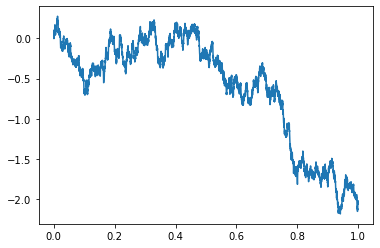

In [6]:
plt.plot(t, x)
plt.show()

In [7]:
print(f'Estimate of D_L is: {EstimateD_L(x, T_lim, N)}')
print(f'Estimate of D_A is: {EstimateD_A(x, T_lim, N)}')
print(f'Estimate of D_Ldelta is: {EstimateD_Ldelta(x, T_lim, N)}')
print(f'Estimate of D_MLE is: {EstimateD_MLE(x, T_lim, N)}')

Estimate of D_L is: 1.039746496917783
Estimate of D_A is: 3.3800092143147924
Estimate of D_Ldelta is: 1.5522826631486961
Estimate of D_MLE is: 0.6011858663172702


In [8]:
x_0 = 0.0
k = 0.0
T_lim = np.array([0, 1])
N = 10000
D = 1.0
M = 10000
D_L = np.zeros(M)



for i in range(M):

    t, x = EulerMaruyamaMethod(x_0, k, T_lim, N, D)
    D_L[i] = EstimateD_L(x, T_lim, N)
   

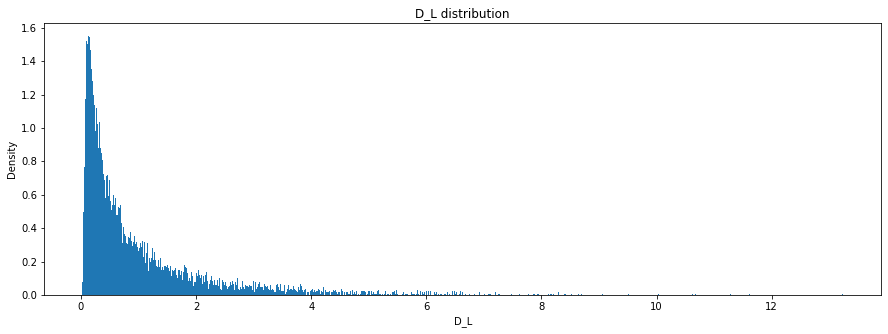

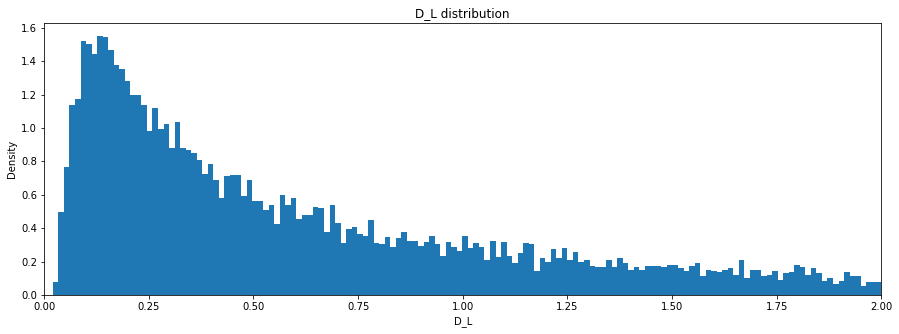

In [9]:
plt.figure(figsize=(15, 5))
plt.title('D_L distribution')
plt.xlabel('D_L')
plt.ylabel('Density')
plt.hist(D_L, bins=1000, density=True)
plt.show()
plt.figure(figsize=(15, 5))
plt.title('D_L distribution')
plt.xlabel('D_L')
plt.ylabel('Density')
plt.xlim([0, 2])
plt.hist(D_L, bins=1000, density=True)
plt.show()

In [135]:
print(np.mean(D_L))

0.0


D_L

In [7]:
x_0 = 0.0
k = 0.0
T_lim = np.array([0, 1])
N = 10000
D = 1.0
M = 10000
D_A = np.zeros(M)



for i in range(M):

    t, x = EulerMaruyamaMethod(x_0, k, T_lim, N, D)
    D_A[i] = EstimateD_A(x, T_lim, N)
   

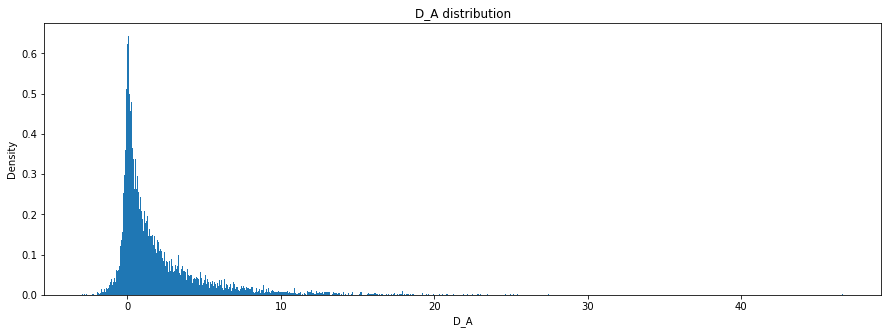

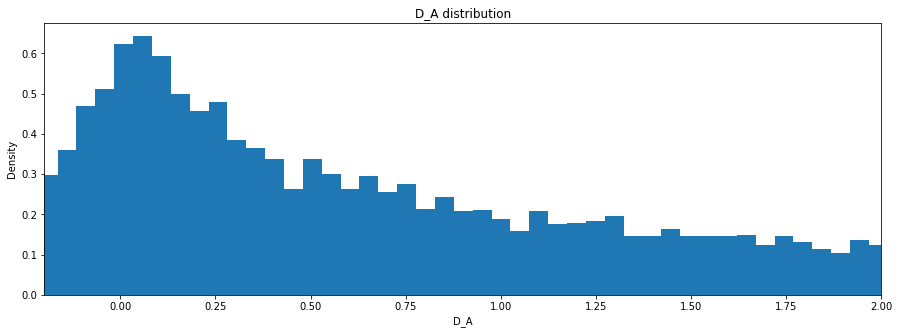

In [8]:
plt.figure(figsize=(15, 5))
plt.title('D_A distribution')
plt.xlabel('D_A')
plt.ylabel('Density')
plt.hist(D_A, bins=1000, density=True)
plt.show()
plt.figure(figsize=(15, 5))
plt.title('D_A distribution')
plt.xlabel('D_A')
plt.ylabel('Density')
plt.xlim([-0.2, 2])
plt.hist(D_A, bins=1000, density=True)
plt.show()

In [ ]:
print(np.mean(D_A))

D_A

In [ ]:
x_0 = 0.0
k = 0.0
T_lim = np.array([0, 1])
N = 10000
D = 1.0
M = 10000
D_Ldelta = np.zeros(M)



for i in range(M):

    t, x = EulerMaruyamaMethod(x_0, k, T_lim, N, D)
    D_Ldelta[i] = EstimateD_Ldelta(x, T_lim, N)

In [ ]:
plt.figure(figsize=(15, 5))
plt.title('D_Ldelta distribution')
plt.xlabel('D_Ldelta')
plt.ylabel('Density')
plt.hist(D_Ldelta, bins=1000, density=True)
plt.show()
plt.figure(figsize=(15, 5))
plt.title('D_Ldelta distribution')
plt.xlabel('D_Ldelta')
plt.ylabel('Density')
plt.xlim([0, 2])
plt.hist(D_Ldelta, bins=1000, density=True)
plt.show()

In [ ]:
np.mean(D_Ldelta)

D_Ldelta

In [137]:
x_0 = 0.0
k = 0.0
T_lim = np.array([0, 1])
N = 10000
D = 1.0
M = 10000
D_MLE = np.zeros(M)



for i in range(M):

    t, x = EulerMaruyamaMethod(x_0, k, T_lim, N, D)
    D_MLE[i] = EstimateD_MLE(x, T_lim, N)

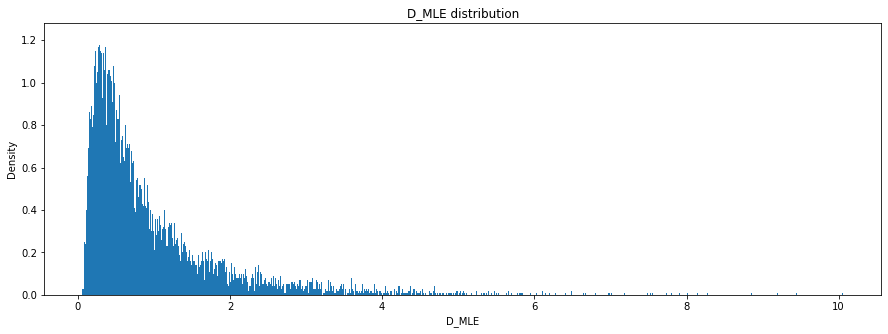

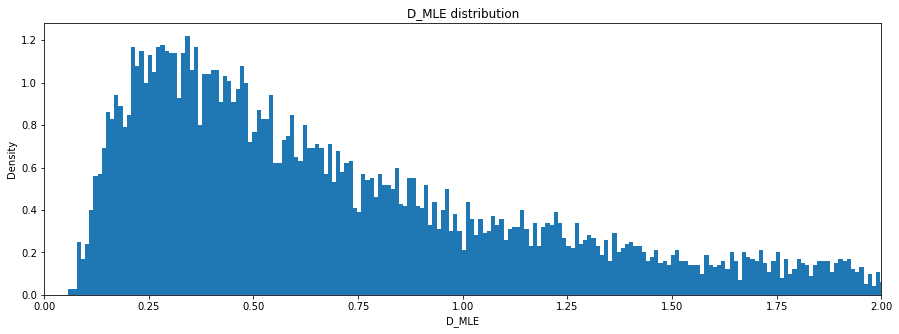

In [138]:
plt.figure(figsize=(15, 5))
plt.title('D_MLE distribution')
plt.xlabel('D_MLE')
plt.ylabel('Density')
plt.hist(D_MLE, bins=1000, density=True)
plt.show()
plt.figure(figsize=(15, 5))
plt.title('D_MLE distribution')
plt.xlabel('D_MLE')
plt.ylabel('Density')
plt.xlim([0, 2])
plt.hist(D_MLE, bins=1000, density=True)
plt.show()

In [139]:
np.mean(D_MLE)

0.9879327968061185

D_MLE

This is end of brownian motion chapter, will need to explain further about this and add details but this is where it ends and then turns to OU

From the above prints I can see that the formula can give an accurate value of D for when k=0. However one thing I notice is that after repeating a few times, the estimate is always below the actual value. This means that the maximum likelihood estimator produces an underestimate of the actual value. 

This approach works for $k=0$, but now I will attempt it for $k>0$. This time it will be useful to take the covariance between diffrent $x$ values instead of just taking the differences. I have found the covariance for a Ornstein-Uhlenbeck process to be:
$$
Cov(X_s X_t) = \frac{D}{K}e^{-k|t-s|}
$$
So now I can calculate the auto covariance in the generated sample and then plot it to find values for k and D. 

Using what we discussed in our meeting, I can change the method of generation of the Ornstein-Uhlenbeck process to be randomly picked from a normal distribution. This is so that the mean of the process over different simulations will be equal to 0, as it will be like it has been taken at an infinite time step. This is because the actual mean of an Ornstein-Uhlenbeck process isn't equal to 0, it is equal to:
$$
E(x_t) = x_0e^{-kt}
$$
where $x_0$ is the intial value. 

The reason we can't set $x_0=0$ is because of the same reason we can't start it at any other value, because we will have to disregard the first $\frac{5}{k}$ points such that the starting distribution matches the Gaussian distribution because the Ornstein-Uhlenbeck process is a Gaussian process. 

However I am not currently sure what the variance of the total distribution should be!!!

So until i figure out what the variance of limiting distribution is, I will instead use the discard method described above. This should give enough time such that the process is normalised and such that the mean is minimal, essentially zero. This is neccessary for working out the covariance of the process as then we will only need the expectation between two points and not the mean of both of them. That is:
$$
Cov(x_t x_{t+\tau}) = E(x_t x_{t+\tau}) - E(x_t) E(x_{t+\tau})
$$
But we will assume:
$$
E(x_t)=0,  E(x_{t+\tau})=0
$$
So we reult in:
$$
Cov(x_t x_{t+\tau}) = E(x_t x_{t+\tau})
$$
So to get this expectation value, with a known mean to be 0, will result in the same method as before with the sample mean of the two values to be:
$$
E(x_t x_{t+\tau}) = \frac{1}{n-\tau} (\sum_{i=0}^{n-\tau} x_i x_{i+\tau})
$$

In [126]:
def EstimateCovariance(x, N, n):
    '''
    Return the maximum likelihood estimator of the autocovariance of tau
    '''
    return np.array([x[tau:]@x[:N-tau]/(N-tau) for tau in range(n)])

In [150]:
x_0 = 0.0
k = 1.0
T_lim = np.array([0, 10])
N = 10000
D = 1.0
min_t = int(np.ceil(5/k))
min_N = int(min_t*N/(T_lim[1]-T_lim[0]))

t, x_prime = EulerMaruyamaMethod(x_0, k, [T_lim[0]-min_t, T_lim[1]], N + min_N, D)
x = x_prime[min_N+1:]
n = int(np.ceil(np.sqrt(N)))
taus = np.arange(n)
covs = EstimateCovariance(x, N, n)
    


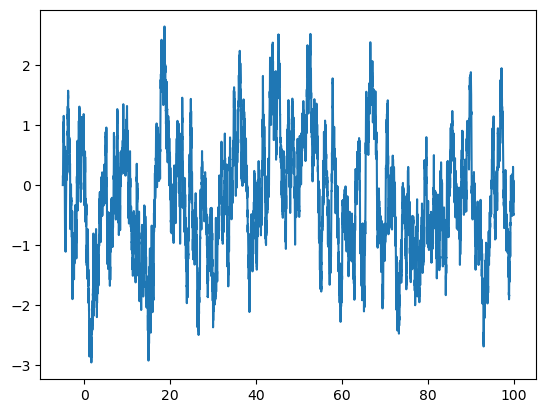

In [128]:
plt.plot(t, x_prime)
plt.show()

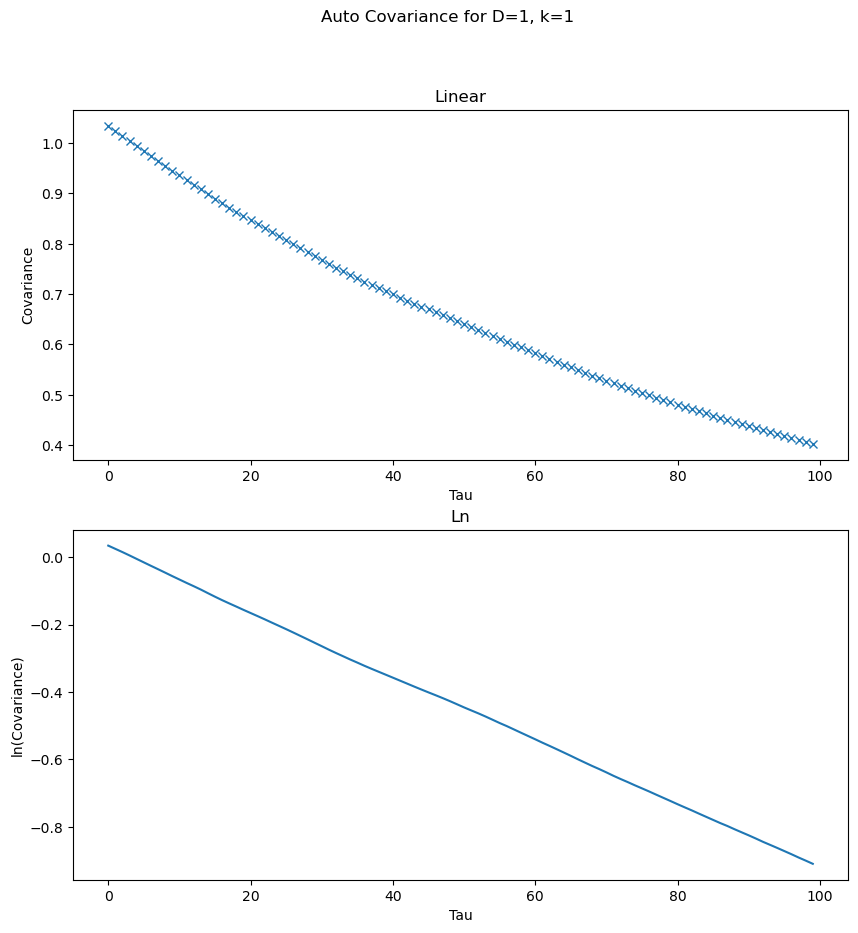

In [142]:

fig, axi = plt.subplots(2, figsize=(10, 10))
fig.suptitle('Auto Covariance for D=1, k=1')

axi[0].plot(taus, covs, 'x')
axi[0].set_title(f'Linear')
axi[0].set_xlabel('Tau')
axi[0].set_ylabel('Covariance')

axi[1].plot(taus, np.log(covs))
axi[1].set_title(f'Ln')
axi[1].set_xlabel('Tau')
axi[1].set_ylabel('ln(Covariance)')
plt.show()

So now I have created a method of plotting the Auto Covariance sequence I can now strt to find out what k and D are from it. On the log/lin plot I can work it out to be $ln(Cov) = ln(D) - ln(k) - k\tau$. First of which I have an isolated $-k\tau$ which shows that on the log/lin plot $-k$ is the gradient to which i can work out. From this I can then work out $ln(D) = ln(Cov) + ln(k)$ when $\tau = 0$. Then can do $e^{ln(D)} = D$. 

To get the gradient of the graph, as it isn't a perfect line, and is prone so not be consistent overall I can use different methods of extracting the best line of fit, or even giving a higher weighting to smaller $\tau$ values as they have more data points to use so are assumed to have a better fit, but as I have only used $\tau \in [0, 100]$ this is a small number compared to the total N and such should be pretty linear so can just take the gradient from the first and last point.


Then we have estimates of $k, D$ from the estimate of the autocovariance plot. To get different estimates of $k, D$ we can either use different estimates of the autocovariance or we can run it multiple times to get get different autocovariances for different simulations. 

In [9]:
def Estimate_k_D(N, T_lim, cov, taus):
    '''
    Return the estimates of k and D from the autocovariance estimate
    '''
    dt = (T_lim[1] - T_lim[0])/N
    lncov = np.array([np.log(cov[0]), np.log(cov[-1])])
    k = (lncov[0]-lncov[-1])/((taus[-1]-taus[0])*dt)
    lnD = lncov[0] + np.log(k)
    D = np.exp(lnD)
    return k, D
    

In [143]:
Estimate_k_D(N, T_lim, covs, taus)

(0.9535630869068024, 0.9867372395977183)

From this result it doesn't seem very useful, but if we increase the amount of simulations we give it we can see the distrbution of the estimator used to see if it gives useful results for k and D.

In [132]:
x_0 = 0.0
k = 1.0
T_lim = np.array([0, 10])
N = 10000
n = int(np.ceil(np.sqrt(N)))
M = 10000
D = 1.0
min_t = int(np.ceil(5/k))
min_N = int(min_t*N/(T_lim[1]-T_lim[0]))

cov = np.zeros(n)
taus = np.arange(n)
k_prime = np.ones(M)
D_prime = np.ones(M)

for i in range(M):
    t, x_prime = EulerMaruyamaMethod(x_0, k, [T_lim[0]-min_t, T_lim[1]], N + min_N, D)
    x = x_prime[min_N+1:]
    cov = EstimateCovariance(x, N, n)
    k_prime[i], D_prime[i] = Estimate_k_D(N, T_lim, cov, taus)


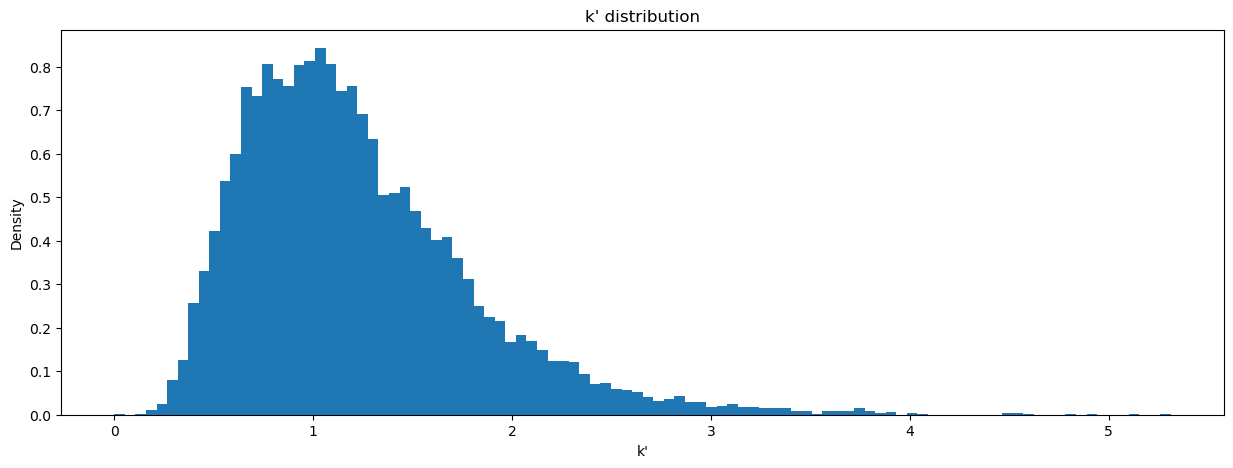

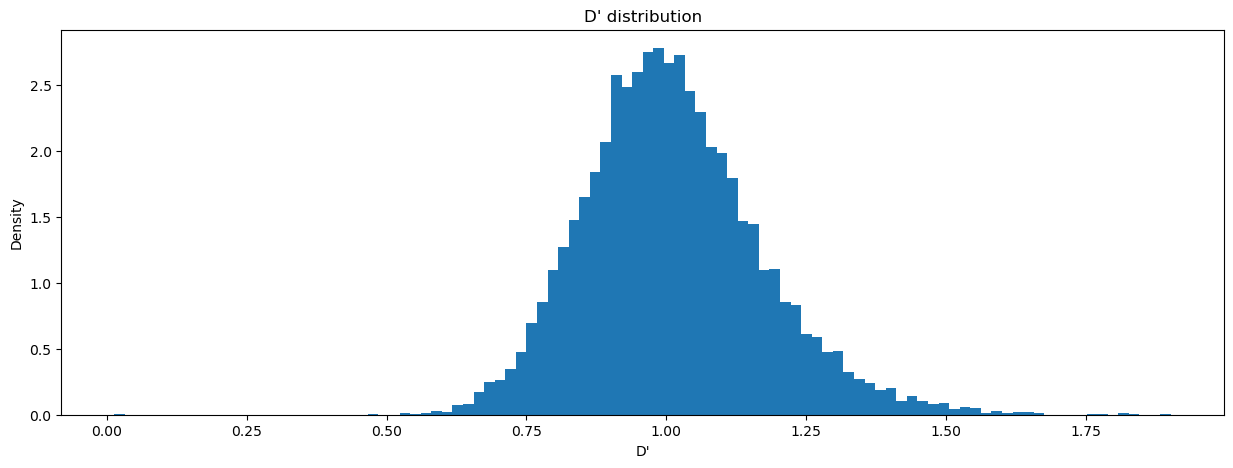

In [323]:
plt.figure(figsize=(15, 5))
plt.title('k\' distribution')
plt.xlabel('k\'')
plt.ylabel('Density')
plt.hist(k_prime, bins=100, density=True)
plt.show()
plt.figure(figsize=(15, 5))
plt.title('D\' distribution')
plt.xlabel('D\'')
plt.ylabel('Density')
plt.hist(D_prime, bins=100, density=True)
plt.show()

From the plots above can see that they produce results that seem to have maximal values, but those values are not close to the actual values of $k, D = 1.0$. 

need to fix

Now I can look to improve the estimation of the autocovariance. Using this approach would entail swapping the notation of $B_t^2$ in the Boyer and Dean paper with $X_t X_{t+\tau}$. This then gives the results in Boyer and Dean when $\tau=0$. So now I can adapt my previous algorithms to account for the difference.

To estimate the values of D and k using least squares estimation, you will need to have a dataset of observations of the variable x at different time points.

Then define the model for the covariance of x as a function of D and k: $\mathbb{E}[x_t x_{t+\tau}] = \frac{D}{k} e^{-k |\tau |}$

Create a matrix of the covariances between each pair of observations in the dataset. This matrix is known as the covariance matrix, and its elements should be calculated using the model defined in step 1.

Perform a non-linear least squares optimization to minimize the sum of the squares of the differences between the elements of the covariance matrix calculated in step 2 and the corresponding elements of the covariance matrix of the dataset.

The values of D and k that minimize this sum of squares are the estimated values for D and k.

In [240]:
# Will be the same functions as before but using built in functions within scipy
from scipy.optimize import least_squares, minimize


def Estimate_k_D_A(covs, T_lim, N, n):
    dt = (T_lim[1] - T_lim[0])/N

    def Autocovariance_loss(kD, tau, cov):
        '''
        The actual autocovariance given estimates of D, k minus the sample autocovariance
        kD[0] = k, kD[1] = D
        '''
        return ((kD[1]/kD[0]) * np.exp(-kD[0]*dt*tau) - cov)**2

    ls_est = least_squares(Autocovariance_loss, np.ones(2), args=(taus, covs))
    return ls_est.x


def Estimate_k_D_MLE(covs, T_lim, N, n):
    dt = (T_lim[1] - T_lim[0])/N

    def Negative_log_likelihood(kD, tau, cov):
        '''
        The negative log likelihood using the estimated and actual sampled covariances
        kD[0] = k, kD[1] = D
        '''
        est_cov = (kD[1]/kD[0]) * np.exp(-kD[0]*dt*tau)
     
        return np.mean(0.5*np.log(est_cov) + 0.5*cov/est_cov)
    
    mle_est = minimize(Negative_log_likelihood, np.ones(2), args=(taus, covs), bounds = ((1e-5, None), (1e-5, None)))
    return mle_est.x



$L(D,k | x) = (2\pi)^{-\frac{n}{2}} |\Sigma|^{-\frac{1}{2}} exp(-\frac{1}{2}x^T\Sigma^{-1}x)$

$logL(D,k|X) = -\frac{n}{2}log(2\pi) -\frac{1}{2}log|\Sigma| -\frac{1}{2}X^T\Sigma^{-1}X$

$logL(D,k|\mathbb{E}[x_t x_{t+\tau}]) = -\frac{n}{2} log(2\pi) - \frac{1}{2} log|\Sigma| - \frac{1}{2} (\mathbb{E}[x_t x_{t+\tau}] - \frac{D}{k} e^{-k |\tau |})^T \Sigma^{-1} (\mathbb{E}[x_t x_{t+\tau}] - \frac{D}{k} e^{-k |\tau |})$

$\frac{\partial logL}{\partial D} = -\frac{1}{2D} + \frac{1}{2}\sum_{i=1}^{n}\sum_{j=1}^{n}(\frac{D}{k} e^{-k |i-j|})(X_iX_j)$


$\frac{\partial logL}{\partial k} = -\frac{n}{2k} + \frac{1}{2}\sum_{i=1}^{n}\sum_{j=1}^{n}(\frac{D}{k} e^{-k |i-j|})(X_iX_j) |i-j|$

In [181]:
x_0 = 0.0
k = 1.0
T_lim = np.array([0, 10])
N = 10000
n = int(np.ceil(np.sqrt(N)))
M = 10000
D = 1.0
min_t = int(np.ceil(5/k))
min_N = int(min_t*N/(T_lim[1]-T_lim[0]))


cov = np.zeros(n)
taus = np.arange(n)
k_A = np.ones(M)
D_A = np.ones(M)

for i in range(M):
    t, x_prime = EulerMaruyamaMethod(x_0, k, [T_lim[0]-min_t, T_lim[1]], N + min_N, D)
    x = x_prime[min_N+1:]
    
    covs = EstimateCovariance(x, N, n)
    k_A[i], D_A[i] = Estimate_k_D_A(covs, T_lim, N, n)


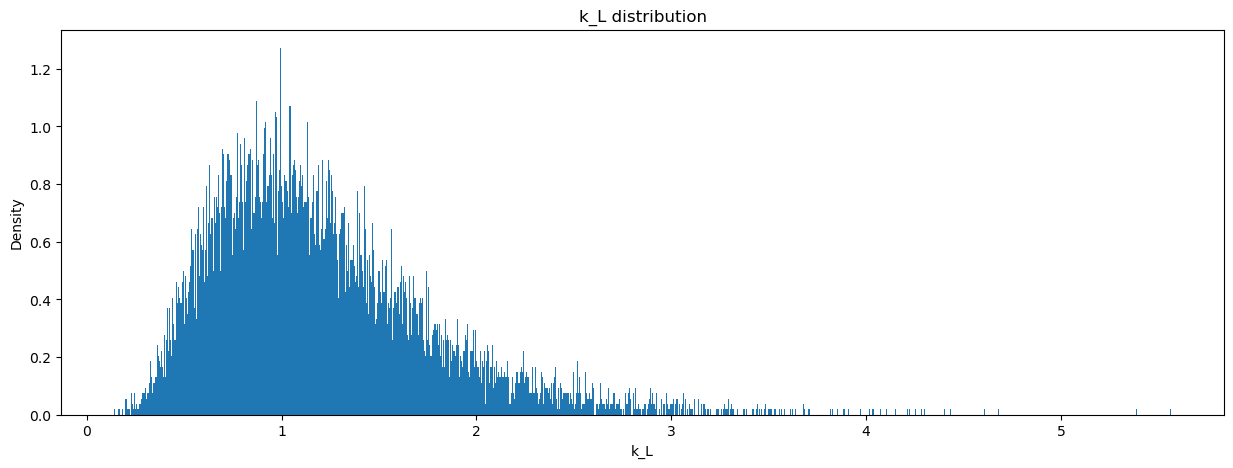

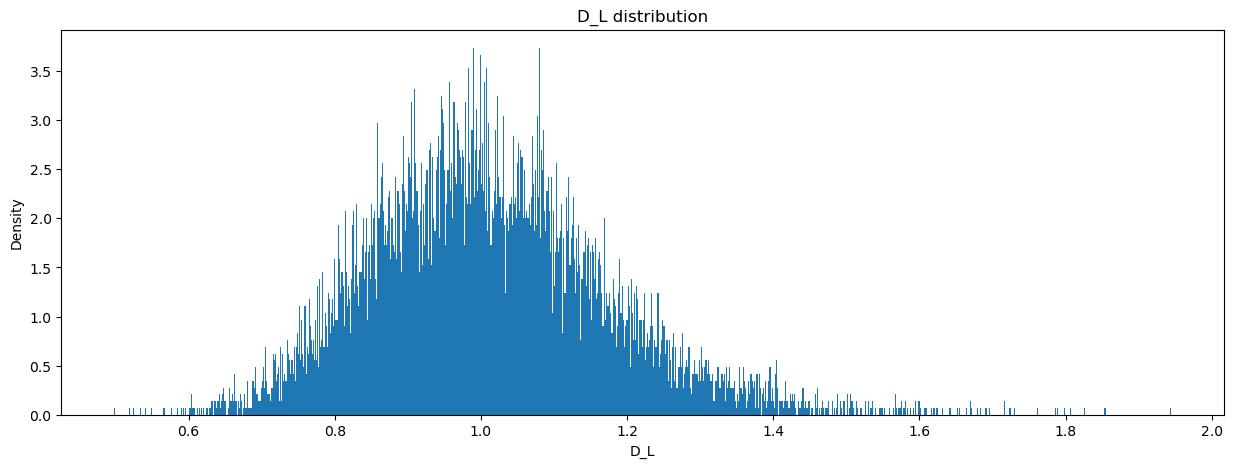

In [177]:
plt.figure(figsize=(15, 5))
plt.title('k_L distribution')
plt.xlabel('k_L')
plt.ylabel('Density')
plt.hist(k_A, bins=1000, density=True)
plt.show()
plt.figure(figsize=(15, 5))
plt.title('D_L distribution')
plt.xlabel('D_L')
plt.ylabel('Density')
plt.hist(D_A, bins=1000, density=True)
plt.show()

In [241]:
x_0 = 0.0
k = 1.0
T_lim = np.array([0, 10])
N = 10000
n = int(np.ceil(np.sqrt(N)))
M = 1
M = 10000
D = 1.0
min_t = int(np.ceil(5/k))
min_N = int(min_t*N/(T_lim[1]-T_lim[0]))


cov = np.zeros(n)
taus = np.arange(n)
k_MLE = np.ones(M)
D_MLE = np.ones(M)

for i in range(M):
    t, x_prime = EulerMaruyamaMethod(x_0, k, [T_lim[0]-min_t, T_lim[1]], N + min_N, D)
    x = x_prime[min_N+1:]

    covs = EstimateCovariance(x, N, n)
    k_MLE[i], D_MLE[i] = Estimate_k_D_MLE(covs, T_lim, N, n)

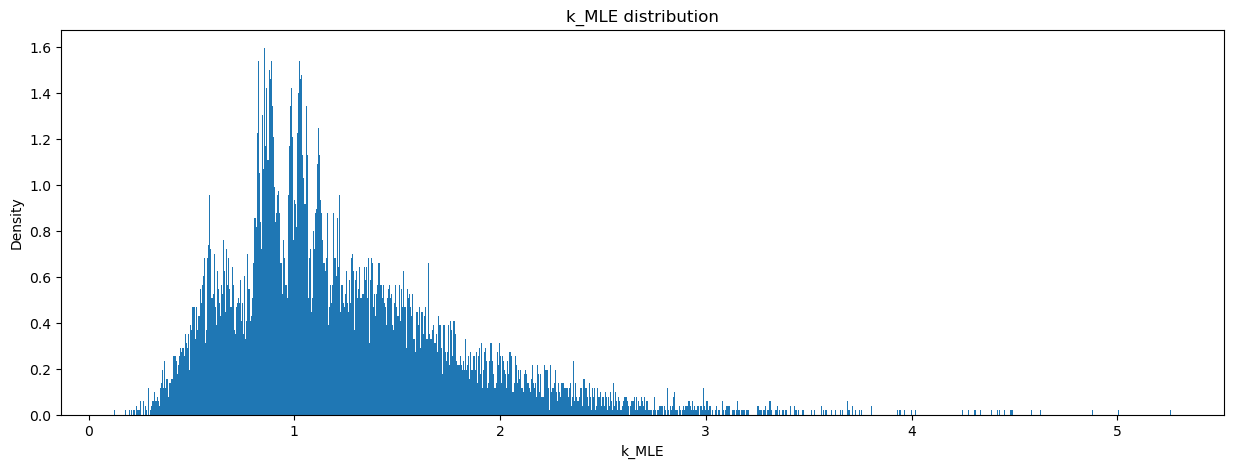

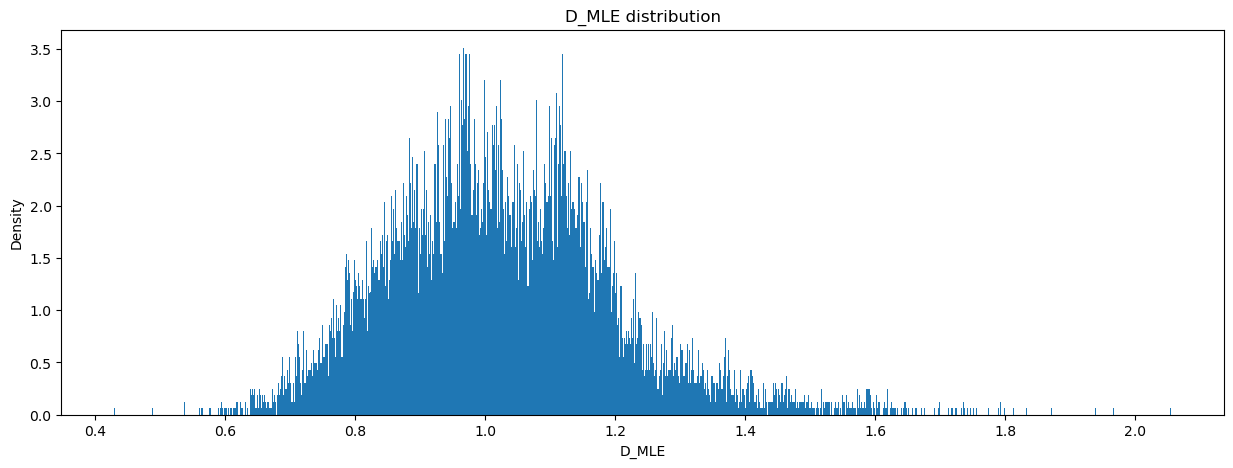

In [244]:
plt.figure(figsize=(15, 5))
plt.title('k_MLE distribution')
plt.xlabel('k_MLE')
plt.ylabel('Density')
plt.hist(k_MLE, bins=1000, density=True)
plt.show()
plt.figure(figsize=(15, 5))
plt.title('D_MLE distribution')
plt.xlabel('D_MLE')
plt.ylabel('Density')
plt.hist(D_MLE, bins=1000, density=True)
plt.show()

this is the end of ou processes

Now we turn to fractional brownian motion

In [245]:
from fbm import FBM
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [251]:
f = FBM(n=10000, hurst=0.25, length=1)
fbm_sample = f.fbm()
t = f.times()

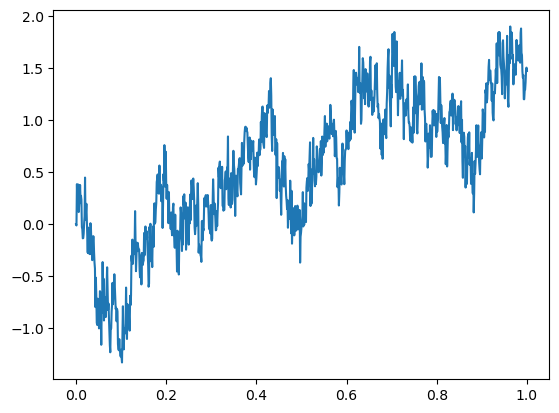

In [250]:
plt.plot(t, fbm_sample)
plt.show()

From this we can see that we only have fBM for times 0 to 1. However we can use the self-similarity of fBM which says that:
$$
B_H(at) \sim |a|^H B_H(t)
$$
So if I want to change it from being from $[0, 1]$ to say $[0, 10]$, Then $a=10$ and such can tranform the original with $B_H[0, 10] = 10^H B_H[0,1]$. 

I will also want to add the diffusion constant of $2D$ to the covariance values and such will need to times each value by the constant of $\sqrt{2D}$.

This is a useful tip for changing the fBM to different time limits. 



I have now got fractional brownian motion, now time to guess hurst value, can use the estimators before on brownian motion.

We can work out that:
$$
Cov(t, s) = \frac{|t|^{2H} + |s|^{2H} - |t-s|^{2H}}{2}
$$
$$
Cov(t, t + \tau) = \frac{|t|^{2H} + |t + \tau|^{2H} - |\tau|^{2H}}{2}
$$
$$
Var(t) = |t|^{2H}
$$
Using this last equation, we can then put out brownian motion predictors to work. That is we can then start to work out:
$$
log(Var(t)) = 2Hlog(|t|)
$$
So we can use the same approximation ideas as before, but this time we can log the function to make it linear in terms of H. This also works with the idea that we just take the log of each of the squares of fBm values and then it creates:
$$
\mathbb{E}(log(W_t^2)) = log(\mathbb{E}(W_t^2)) =  2Hlog(|t|)
$$
$$
F = \int_0^1 [log(W_t^2) - l(t)]^2 dt
$$
This looks a lot like equation (1) from the paper that gave us the distributions for the Brownian Motion. I can then expand out the integral to get values of the estimates of the Hurst value.


We can then start to get the same estimates as before with,
$$
l(t) = a_L log(t)
$$
We can then minimize this to get:
$$
a_L = \frac{\int_0^1 log(t) log(W_t^2) dt}{2}
$$


!!!!!!!!!!!!!!!!!!!!!!!!!!

need to do, but isnt neccessary for purpose

!!!!!!!!!!!!!!!!!!!!!!!!!!!

Now we can adapt this to if the hurst coefficient is known, can we figure out what $D$ is from the covariance when we adapt it to be in the same format as before.
We can work out that:
$$
Cov(t, s) = 2D \frac{|t|^{2H} + |s|^{2H} - |t-s|^{2H}}{2}
$$
$$
Cov(t, t + \tau) = 2D\frac{|t|^{2H} + |t + \tau|^{2H} - |\tau|^{2H}}{2}
$$
$$
Var(t) = 2D|t|^{2H}
$$

From these equations we can then look to estimate D in a similar method to brownian motion. We can take: 
$$\mathbb{E}(W_t^2) = 2D |t|^{2H} = a |t|^{2H} $$
So we can first take the least squares estimate to be:
$$
F = \int_0^1[W_t^2 - l(t)]^2 dt
$$
where $l(t) = a_L |t|^{2H}$. We can then minimise this to give an estimate of $a_L$ to be:
$$
a_L = (4H+1) \int_0^1 t^{2H} W_t^2 dt
$$
We can also work out the MLE estimate from the likelihood of $W_t$ defined as:
$$
L = \prod_{t=0}^1 (2 \pi a t^{2H})^{-1/2} e^{-\frac{W_t^2}{2a t^{2H}}}
$$
I can minimize this to get:
$$
a_{MLE} = \int_0^1 \frac{W_t^2}{t^{2H}} dt
$$


In [325]:
def Estimatea_L(x, N, H):
    '''
    Return the a_L estimator of the variance when k=0
    '''
    a_L = (4*H + 1)*np.mean(np.linspace(0, 1, N+1)[1:]**(2*H)*x**2)
    return a_L


def Estimatea_MLE(x, N, H):
    '''
    Return the a_MLE estimator of the variance when k=0
    '''
    a_MLE = np.mean(x**2/np.linspace(0, 1, N+1)[1:]**(2*H))
    return a_MLE


H = 0.25

In [2]:
H = 0.25
N = 10000
M = 10000
burnin = 1000
W = np.zeros((M, N))
f = FBM(n=N+burnin-1, hurst=H)
for i in range(M):
    W[i] = f.fbm()[burnin:]


In [10]:
W_pd = pd.DataFrame(W)
W_pd.to_csv('fbm_H_0_25.csv', index = False)

To save time as it takes 30 minutes to compute but only 2 minutes to read in.

In [296]:
W_pd = pd.read_csv('fbm_H_0_25.csv')
W_0_25 = W_pd.to_numpy()
H_0_25 = 0.25
N = 10000
M = 10000

In [326]:
a_L = np.zeros(M)
for i in range(M):
    a_L[i] = Estimatea_L(W_0_25[i], N, H_0_25)


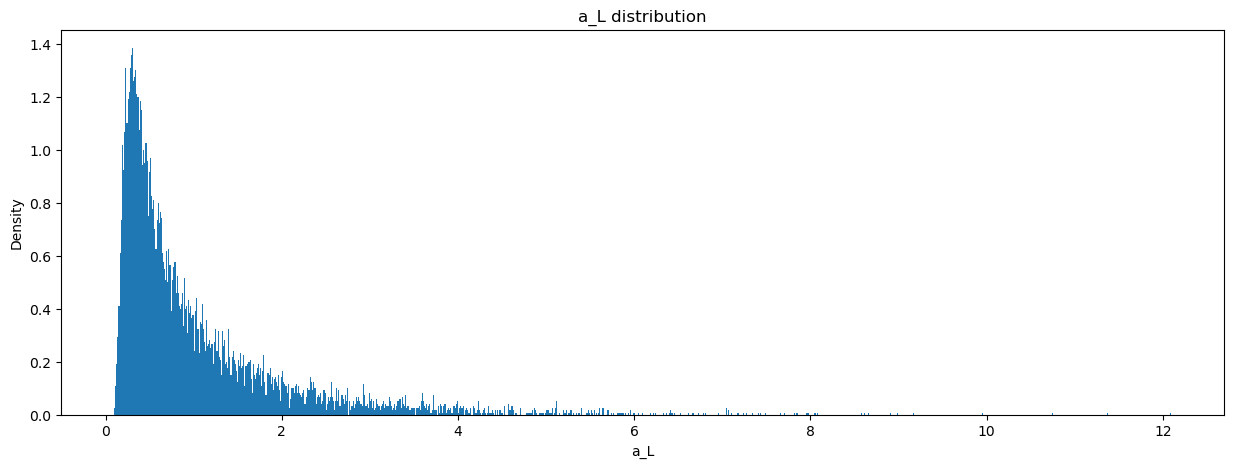

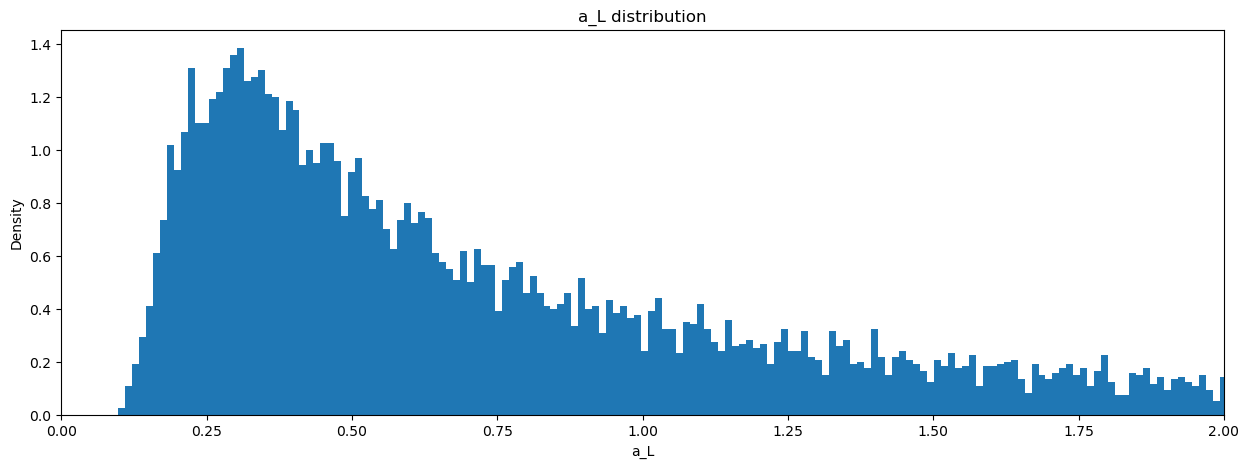

In [327]:
plt.figure(figsize=(15, 5))
plt.title('a_L distribution')
plt.xlabel('a_L')
plt.ylabel('Density')
plt.hist(a_L, bins=1000, density=True)
plt.show()
plt.figure(figsize=(15, 5))
plt.title('a_L distribution')
plt.xlabel('a_L')
plt.ylabel('Density')
plt.xlim([0, 2])
plt.hist(a_L, bins=1000, density=True)
plt.show()

In [328]:
a_L.mean()

1.0346303047644931

In [329]:
a_MLE = np.zeros(M)
for i in range(M):
    a_MLE[i] = Estimatea_MLE(W_0_25[i], N, H_0_25)


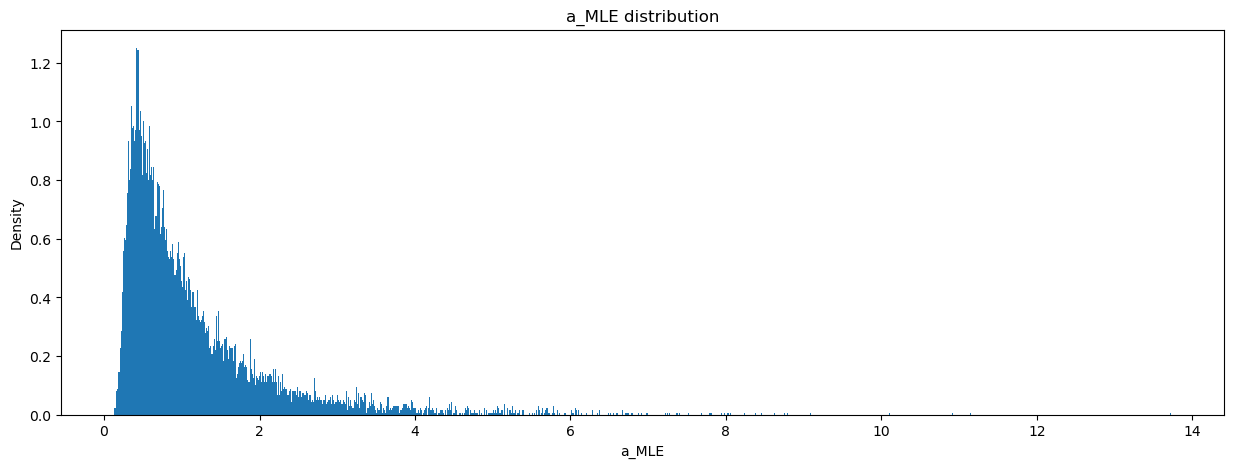

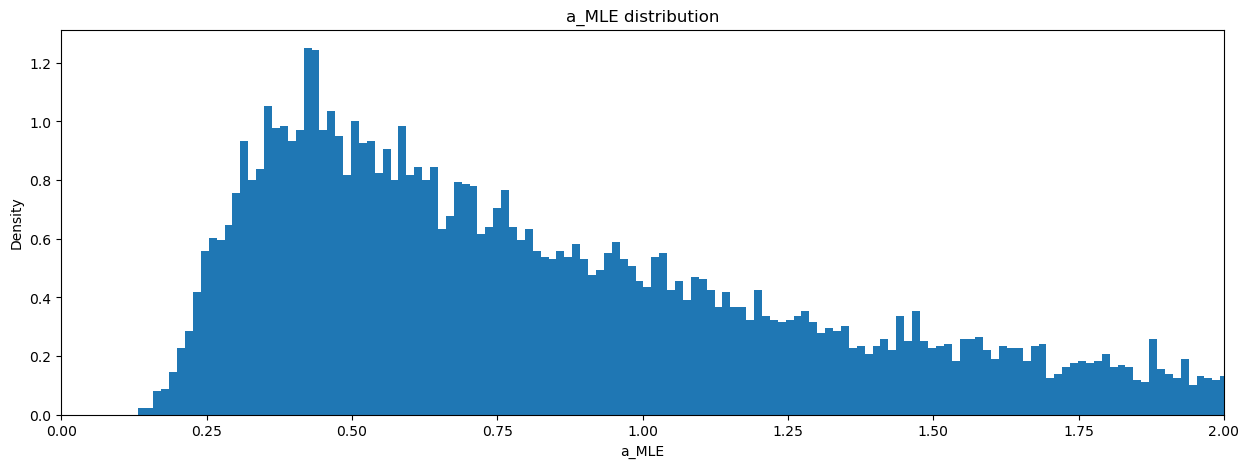

In [330]:
plt.figure(figsize=(15, 5))
plt.title('a_MLE distribution')
plt.xlabel('a_MLE')
plt.ylabel('Density')
plt.hist(a_MLE, bins=1000, density=True)
plt.show()
plt.figure(figsize=(15, 5))
plt.title('a_MLE distribution')
plt.xlabel('a_MLE')
plt.ylabel('Density')
plt.xlim([0, 2])
plt.hist(a_MLE, bins=1000, density=True)
plt.show()

In [156]:
a_MLE.mean()

1.1603170209734366

H = 0.5

In [298]:
H = 0.5
N = 10000
M = 10000
burnin = 1000
W = np.zeros((M, N))
f = FBM(n=N+burnin-1, hurst=H)
for i in range(M):
    W[i] = f.fbm()[burnin:]


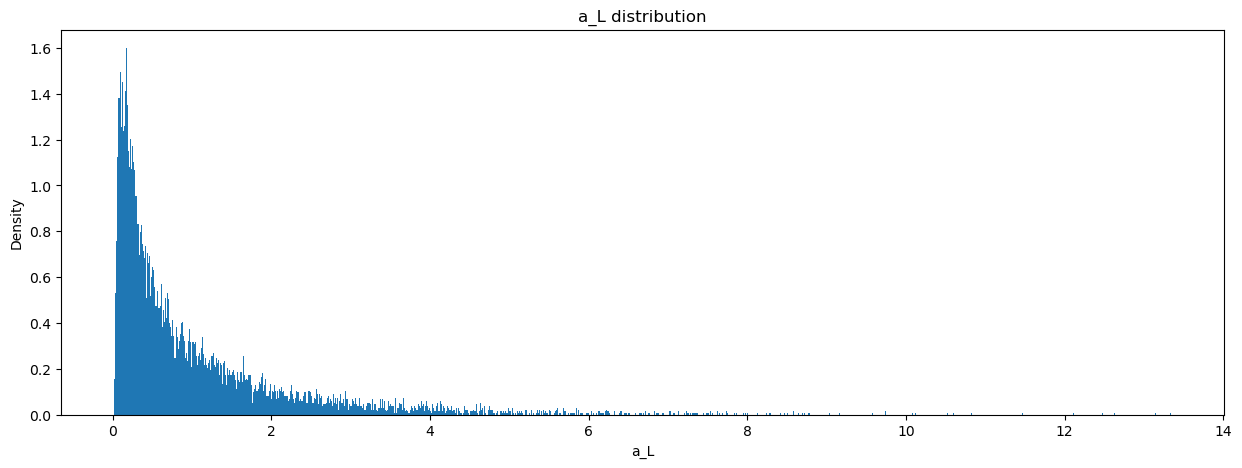

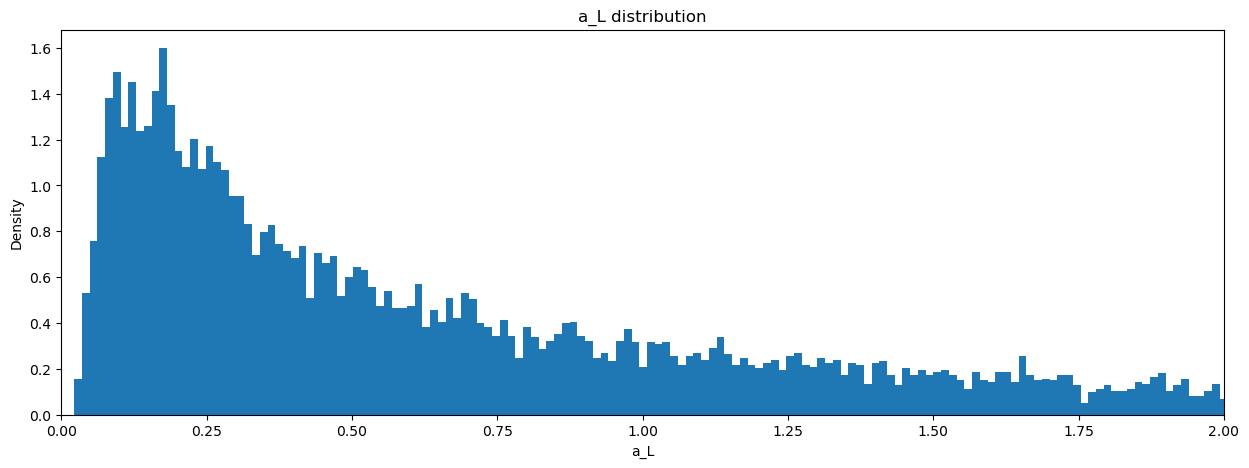

In [29]:
a_L = np.zeros(M)
for i in range(M):
    a_L[i] = Estimatea_L(W[i], N, H)

plt.figure(figsize=(15, 5))
plt.title('a_L distribution')
plt.xlabel('a_L')
plt.ylabel('Density')
plt.hist(a_L, bins=1000, density=True)
plt.show()
plt.figure(figsize=(15, 5))
plt.title('a_L distribution')
plt.xlabel('a_L')
plt.ylabel('Density')
plt.xlim([0, 2])
plt.hist(a_L, bins=1000, density=True)
plt.show()

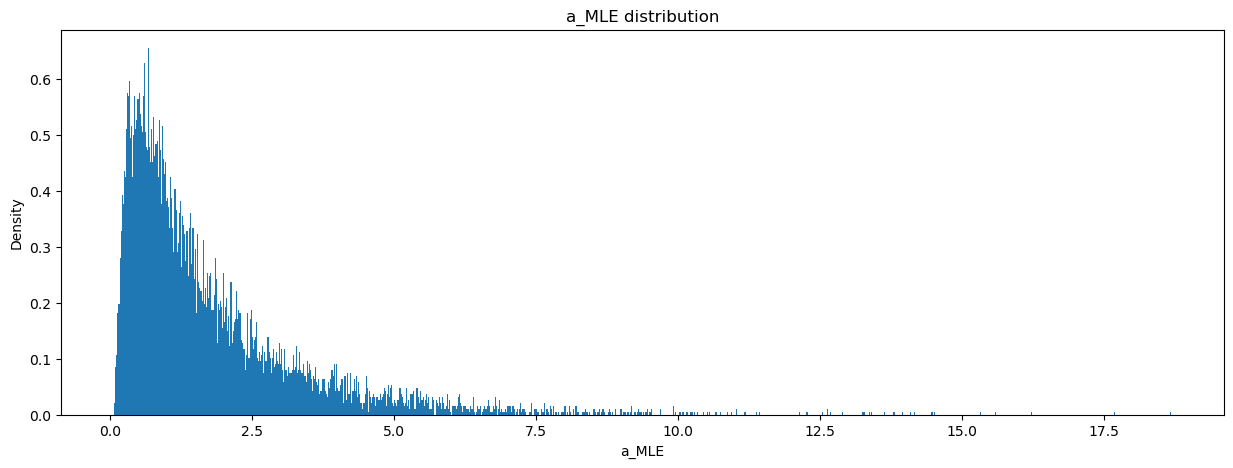

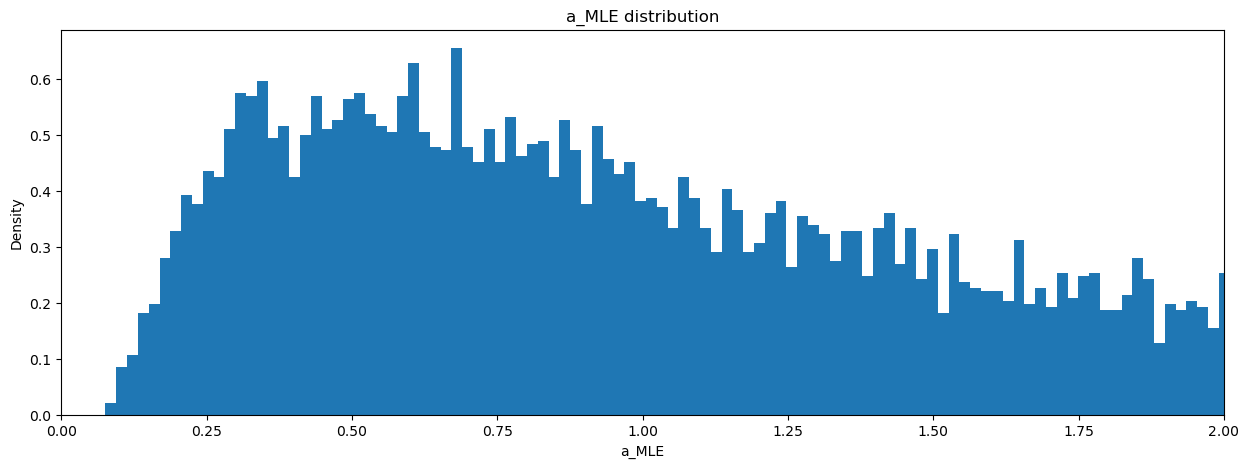

In [30]:
a_MLE = np.zeros(M)
for i in range(M):
    a_MLE[i] = Estimatea_MLE(W[i], N, H)

plt.figure(figsize=(15, 5))
plt.title('a_MLE distribution')
plt.xlabel('a_MLE')
plt.ylabel('Density')
plt.hist(a_MLE, bins=1000, density=True)
plt.show()
plt.figure(figsize=(15, 5))
plt.title('a_MLE distribution')
plt.xlabel('a_MLE')
plt.ylabel('Density')
plt.xlim([0, 2])
plt.hist(a_MLE, bins=1000, density=True)
plt.show()

H = 0.75

In [19]:
H = 0.75
N = 10000
M = 10000
burnin = 1000
W = np.zeros((M, N))
f = FBM(n=N+burnin-1, hurst=H)
for i in range(M):
    W[i] = f.fbm()[burnin:]

In [20]:
W_pd = pd.DataFrame(W)
W_pd.to_csv('fbm_H_0_75.csv', index = False)

To save time as it takes 50 minutes to compute but only 2 minutes to read in.

In [297]:
W_pd = pd.read_csv('fbm_H_0_75.csv')
W_0_75 = W_pd.to_numpy()
H_0_75 = 0.75
N = 10000
M = 10000

In [147]:
a_MLE.mean()

8.029509685490321

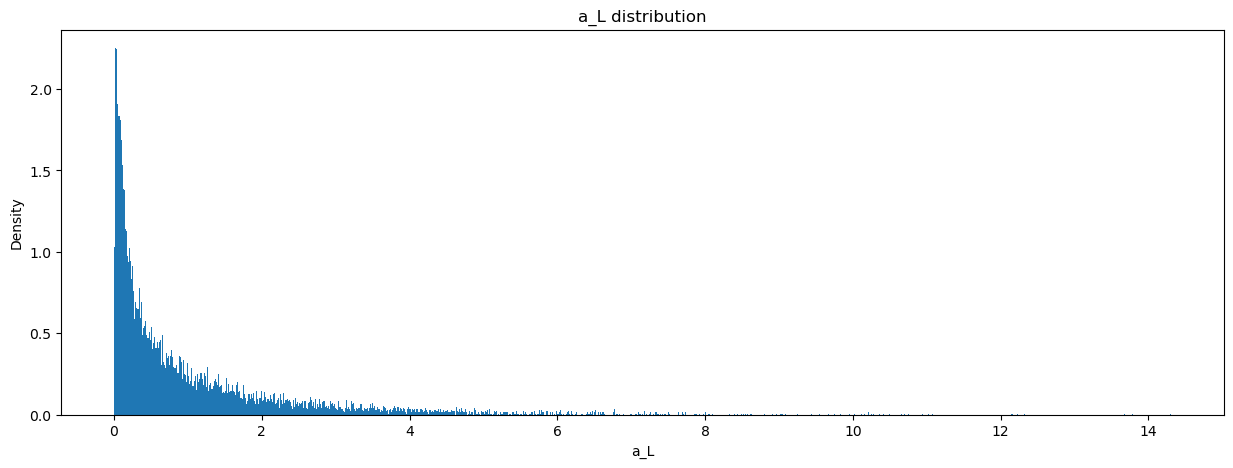

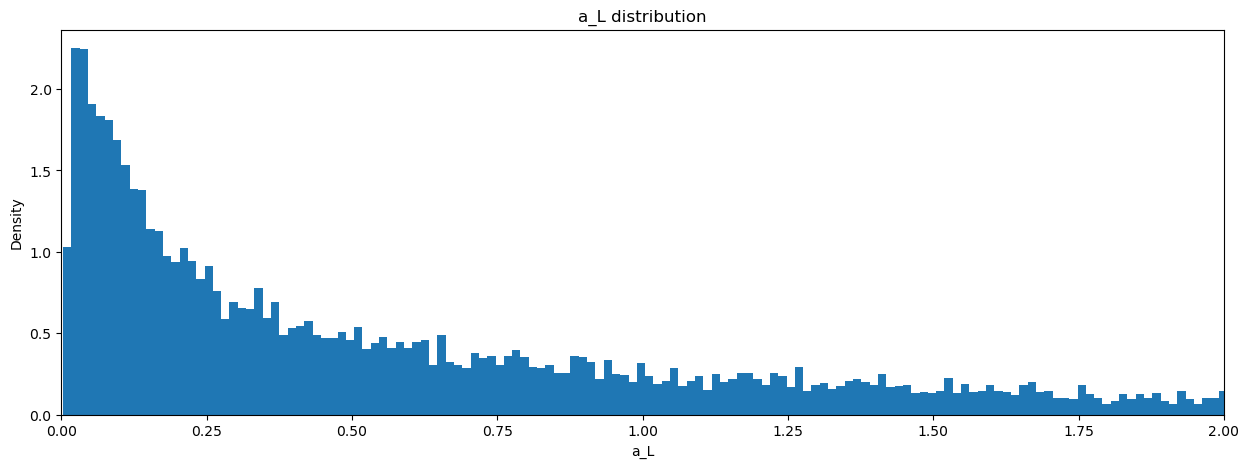

In [331]:
a_L = np.zeros(M)
for i in range(M):
    a_L[i] = Estimatea_L(W_0_75[i], N, H_0_75)

plt.figure(figsize=(15, 5))
plt.title('a_L distribution')
plt.xlabel('a_L')
plt.ylabel('Density')
plt.hist(a_L, bins=1000, density=True)
plt.show()
plt.figure(figsize=(15, 5))
plt.title('a_L distribution')
plt.xlabel('a_L')
plt.ylabel('Density')
plt.xlim([0, 2])
plt.hist(a_L, bins=1000, density=True)
plt.show()

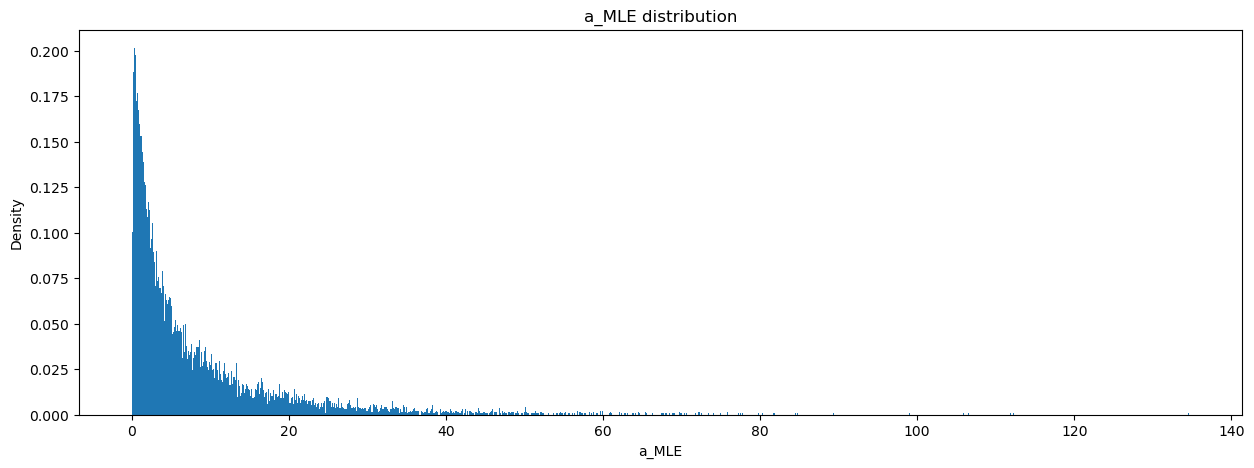

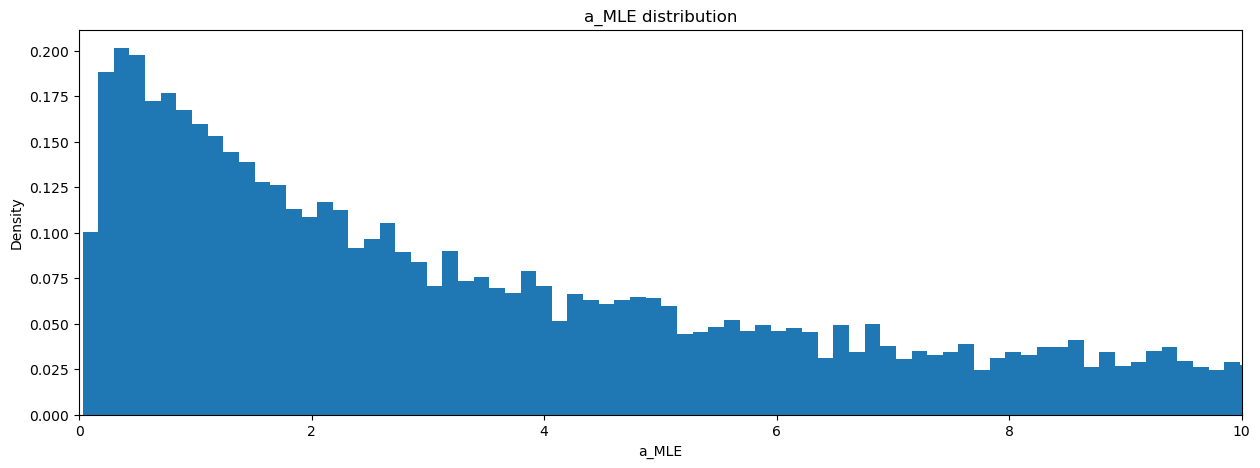

In [332]:
a_MLE = np.zeros(M)
for i in range(M):
    a_MLE[i] = Estimatea_MLE(W_0_75[i], N, H_0_75)

plt.figure(figsize=(15, 5))
plt.title('a_MLE distribution')
plt.xlabel('a_MLE')
plt.ylabel('Density')
plt.hist(a_MLE, bins=1000, density=True)
plt.show()
plt.figure(figsize=(15, 5))
plt.title('a_MLE distribution')
plt.xlabel('a_MLE')
plt.ylabel('Density')
plt.xlim([0, 10])
plt.hist(a_MLE, bins=1000, density=True)
plt.show()

First Passage Time Estimator

The probability of the first passage time for a set $m$ is given below as:
$$\mathbb{P}(\tau) = \frac{m}{ \sqrt{4 \pi D \tau^3} } \exp \left( - \frac{m^2}{4 D \tau} \right)$$
where $m$ is the difference in value, $\tau$ is the difference in time. 

I will make a simplified version of this by simply only considering the start value as ground and then will simply split the output domain into 100 different levels by taking the minimum and maximum value and splitting it accordingly and then I can find the first passage time to each of those levels and then calculate the FPT of the difference in time, with the difference in value. 

I can then use

FPT estimator

In [ ]:
def FPT_prob(m, tau):

    return 


fOU process

In [306]:
def EulerMaruyamaRecursion(x_n, k, dt, e_n):
    '''
    Return the x_{n+1} value using the Euler-Maruyama method recursion.
    '''
    return x_n - k*x_n*dt + e_n

def FractionalEulerMaruyamaMethod(x_0, k, T_lim, N, D, W, H):
    '''
    Complete the Euler-Maruyama method and return the approximated x values at each time value.
    '''
    dt = (T_lim[1] - T_lim[0])/N

    t = np.arange(T_lim[0], T_lim[1]+dt, dt)
    
    x = np.zeros(N+1)
    x[0] = x_0

    w = np.size(W, 0)
    sigma = np.sqrt(2*D*dt)
    e = np.random.normal(0, sigma, N-w)
    sigma = np.sqrt(2*D)
    W = sigma*W
    e = np.concatenate((e, W))
    
    for n in range(N):
        x[n+1] = EulerMaruyamaRecursion(x[n], k, dt, e[n])

    return t, x

In [315]:
# H = 0.25
x_0 = 0.0
k = 1.0
T_lim = np.array([0, 10])
N = 10000
D = 1.0
min_t = int(np.ceil(5/k))
min_N = int(min_t*N/(T_lim[1]-T_lim[0]))

t, x_prime = FractionalEulerMaruyamaMethod(x_0, k, [T_lim[0]-min_t, T_lim[1]], N + min_N, D, np.diff(W_0_25[0])*(T_lim[1] - T_lim[0])**H_0_25, H_0_25)
x = x_prime[min_N+1:]

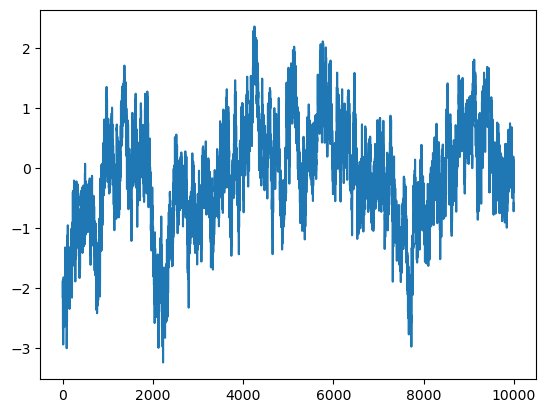

In [318]:
plt.plot(x)
plt.show()

In [319]:
# H = 0.5 BM
x_0 = 0.0
k = 1.0
T_lim = np.array([0, 10])
N = 10000
D = 1.0
min_t = int(np.ceil(5/k))
min_N = int(min_t*N/(T_lim[1]-T_lim[0]))

t, x_prime = FractionalEulerMaruyamaMethod(x_0, k, [T_lim[0]-min_t, T_lim[1]], N + min_N, D, np.diff(W[0])*(T_lim[1] - T_lim[0])**H, H)
x = x_prime[min_N+1:]

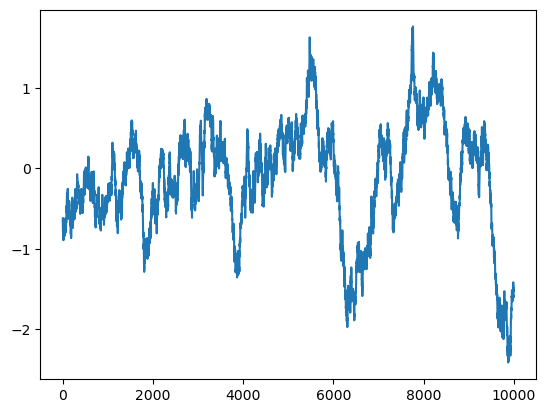

In [320]:
plt.plot(x)
plt.show()

In [321]:
# H = 0.75
x_0 = 0.0
k = 1.0
T_lim = np.array([0, 10])
N = 10000
D = 1.0
min_t = int(np.ceil(5/k))
min_N = int(min_t*N/(T_lim[1]-T_lim[0]))

t, x_prime = FractionalEulerMaruyamaMethod(x_0, k, [T_lim[0]-min_t, T_lim[1]], N + min_N, D, np.diff(W_0_75[0])*(T_lim[1] - T_lim[0])**H_0_75, H_0_75)
x = x_prime[min_N+1:]


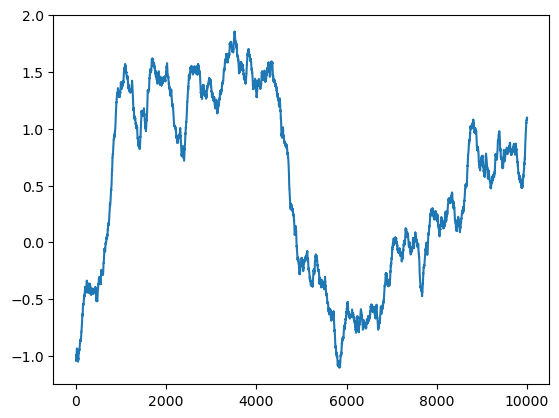

In [322]:
plt.plot(x)
plt.show()


Now I have managed to implement the fractional Ornstein-Uhlenbeck process, I can start to look to optimise this to find out the k and D values.

$\mathbb{E}[x_t x_{t+\tau}] = \frac{D}{k^H} \frac{\Gamma(1-H)}{\Gamma(1+H)} (k|\tau|)^H e^{-k |\tau |}$